# Deep Learning Final Project: "Electricity Price Modelling"


> Shaikh Muhammad Asjad Raza



# **Task description**

---



We are given a dataset which contains historical information about price changes of electricity. Our goal is to predict the price of electricity with a forecast distance of 1 hour with as little error as possibe.  

# **Load libraries**

---



In [ ]:
import pandas as pd 
import csv
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **Load the data**

---



In [ ]:
# Use wget to download the data stored in csv format.#
!wget "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Electricity_data_hourly_products.csv"

--2020-11-08 19:37:27--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Electricity_data_hourly_products.csv
Resolving frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)... 52.219.74.124
Connecting to frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)|52.219.74.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350029849 (334M) [text/csv]
Saving to: ‘Electricity_data_hourly_products.csv’

Electricity_data_ho 100%[===================>] 333.81M  20.5MB/s    in 17s     

2020-11-08 19:37:44 (19.7 MB/s) - ‘Electricity_data_hourly_products.csv’ saved [350029849/350029849]



In [ ]:
# Load the data using the pandas library. Using the 1st (0th) column as index
# Save the raw data in a DataFrame named 'original_df'

import pandas as pd
original_df = pd.read_csv('Electricity_data_hourly_products.csv',parse_dates=['Datetime'], index_col=0)

# Display the first 5 rows of the data; for a description of the content.
display(original_df.head())

# Display basic dataframe info
original_df.info()


contractId  qty    px
Datetime                                      
2020-03-01 11:59:13.229    11629792  0.5 -0.99
2020-03-01 11:59:13.243    11629792  0.5 -0.99
2020-03-01 11:59:13.243    11629792  0.1 -1.00
2020-03-01 11:59:46.669    11629792  3.0 -0.99
2020-03-01 11:59:55.065    11629792  3.0 -0.99

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8219996 entries, 2020-03-01 11:59:13.229000 to 2020-08-24 20:42:39.432000
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   contractId  int64  
 1   qty         float64
 2   px          float64
dtypes: float64(2), int64(1)
memory usage: 250.9 MB


# **Data Exploration**

---



In [ ]:
# Number of contracts in Data
print("Number of contracts: "+ str(original_df['contractId'].nunique()))

Number of contracts: 4196


We have 4196 contracts in total. Each contract is independent w.r.t time (hours, minutes, seconds) from another contract so we can have multiple contracts happening at the same hour. 

We can plot 'px' and 'qty' values contract wise. Since multiple contracts can happen at the same hour, we plot overlapping contracts on top of each other against their px or qty values respectively.  

No handles with labels found to put in legend.


([], <a list of 0 Text major ticklabel objects>)

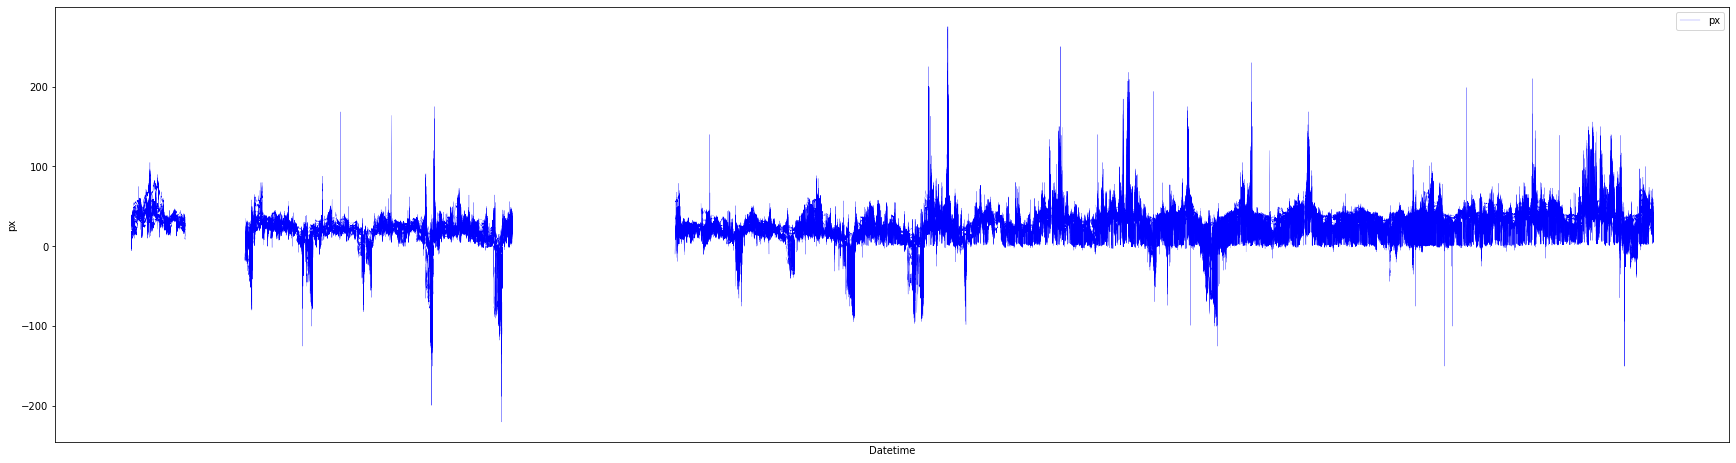

In [ ]:
# Plotting 'px' values contract wise

plt.figure(figsize=(30, 8))
plt.legend(loc="best")

# running the loop seperatly for each contract
for i in original_df['contractId'].unique():
  plt.plot(original_df.index[original_df['contractId']==i], original_df['px'][original_df['contractId']==i].values, linewidth=0.2, color='blue')
  plt.legend(['px'], loc="best")

plt.xlabel('Datetime')
plt.ylabel('px')
plt.xticks([])

No handles with labels found to put in legend.


([], <a list of 0 Text major ticklabel objects>)

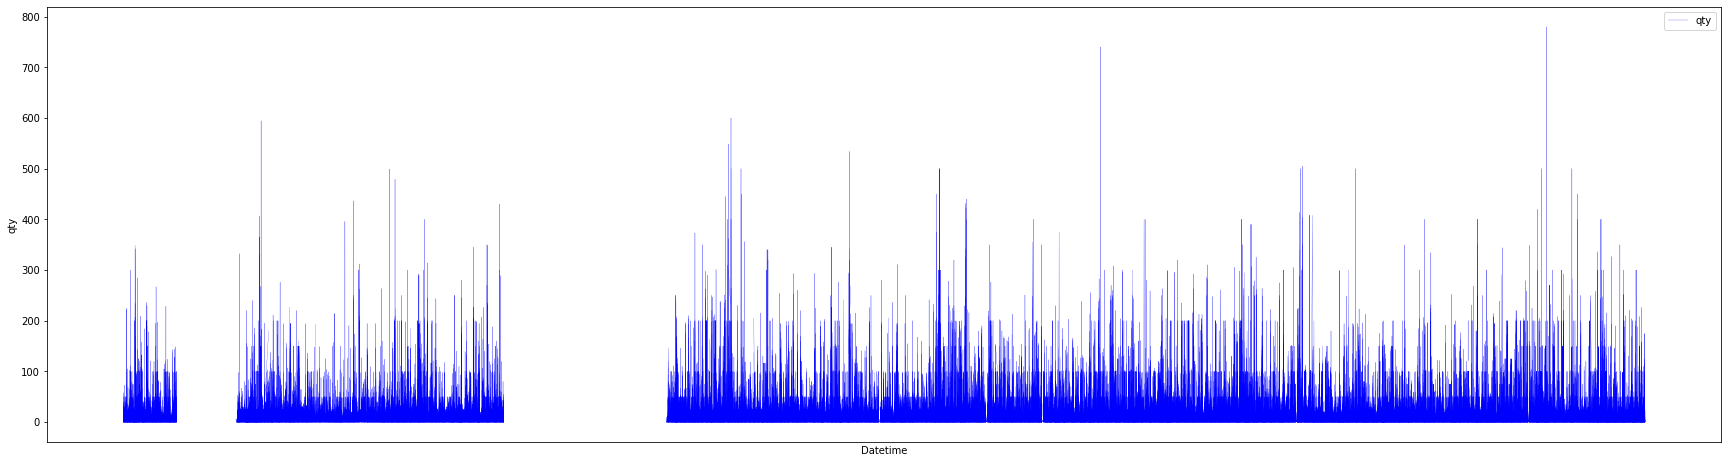

In [ ]:
# Plotting qty values contract wise

plt.figure(figsize=(30, 8))
plt.legend(loc="best")

# running the loop seperatly for each contract
for i in original_df['contractId'].unique():
  plt.plot(original_df.index[original_df['contractId']==i], original_df['qty'][original_df['contractId']==i].values, linewidth=0.2, color='blue')
  plt.legend(['qty'], loc="best")

plt.xlabel('Datetime')
plt.ylabel('qty')
plt.xticks([])

In the abpve 2 plots of px and qty we can see some gaps. These gaps represent the duration during which no trades took place. This may result in missing values when we will be computing OHLC (Open, High, Low, Close) values with hourly binning. The data is volatile and we see peaks at different time period

# **Feature Engineering**

---



#### **Computing the OHLC(Open, High, Low, Close) values for price "px" and quantity 'qty' with hourly binning seperatly for each contract.**



In [ ]:
def bin_ohlcv(df, contractId, item, binning_size='H'):
  df_cid = df[df.contractId == contractId]

  # resample for a binsize and the ohlc the result.
  if item == 'px':
    data = df_cid[['px']].resample(binning_size).ohlc().px

  else:
    data = df_cid[['qty']].resample(binning_size).ohlc().qty
    # add contract_id at the end so that we can index using contractID for future analysis and rolling windows.
    data['contractId'] = contractId
  return data

In [ ]:
# We want to do it seperatly for each contract using unique contractIDs in original dataFrame.
uniques = original_df['contractId'].unique()

# we create seperate dataframes for OHLC of 'px' and 'qty'
ohlc_px_df = pd.DataFrame()
ohlc_qty_df = pd.DataFrame()

# Run the loop for indivisual ContractIDs appending (Hourly) OHLC values for 'px' and 'qty'.
for unique_cid in uniques:
  ohlc_px_df = ohlc_px_df.append(bin_ohlcv(original_df, unique_cid, item = 'px', binning_size='H'))
  ohlc_qty_df = ohlc_qty_df.append(bin_ohlcv(original_df, unique_cid, item='qty', binning_size='H'))

In [ ]:
# print the shapes for ohlc_px_df and ohlc_qty_df 
print(ohlc_px_df.shape, ohlc_qty_df.shape)

(63451, 4) (63451, 5)


#### **Checking If no trades took place during a given hour, use the close price of the last hour to replace the px OHLC values and 0 for qty OHLC values**



In [ ]:
# check missing values for ohlc_px_df
# will be same for ohlc_qty_df
ohlc_px_df.isnull().sum()

open     5664
high     5664
low      5664
close    5664
dtype: int64

In [ ]:
#Percentage of missing Values
ohlc_px_df.isnull().sum().sort_index()/len(ohlc_px_df)

close    0.089266
high     0.089266
low      0.089266
open     0.089266
dtype: float64

While checking for missing values we find that there are about 8% missing values in the data. To tackle these we have put closing values from the last hour to these values. Idea behind this is that during these hours there was no transaction taking place so the closing price of the last hour would be OHLC values for current hour. 

In [ ]:
# This function is only for ohlc values of px.
def fillna_close(df):
    for i in df.iterrows():
        if not np.isnan(i[1]['close']):
            close = i[1]['close']
        else:
            i[1]['open'] = close
            i[1]['high'] = close
            i[1]['low'] = close
            i[1]['close'] = close
    return df

In [ ]:
ohlc_px_df = fillna_close(ohlc_px_df)

# Fill 0 where no trade took place for qty
ohlc_qty_df = ohlc_qty_df.fillna(0)

In [ ]:
# rename the OHLC values for qty
ohlc_qty_df.rename(columns = {'open':'open_qty', 'high':'high_qty', 'low':'low_qty', 'close':'close_qty'}, inplace = True) 

### **Further Assurance that Missing Values has been handled**



In [ ]:
ohlc_px_df.isnull().sum().sort_index()/len(ohlc_px_df)

close    0.0
high     0.0
low      0.0
open     0.0
dtype: float64

### **Join px OHLC and qty OHLC dataframes**

In [ ]:
# join the OHLC px DataFrame and OHLC qty DataFrame
# New dataframe is ohlc_df

ohlc_df = pd.concat([ohlc_px_df, ohlc_qty_df], axis=1)
ohlc_df.head(5)

open   high    low  ...  low_qty  close_qty  contractId
Datetime                                  ...                                
2020-03-01 11:00:00  -0.99  -0.99  -1.00  ...      0.1        0.2    11629792
2020-03-01 11:00:00   1.30   1.71   1.30  ...      1.0        5.0    11629866
2020-03-01 12:00:00   1.71  18.00  -5.57  ...      0.1        2.4    11629866
2020-03-01 11:00:00  18.50  18.50  18.50  ...      0.2        0.2    11629920
2020-03-01 12:00:00  18.11  19.00  16.21  ...      0.1        3.0    11629920

[5 rows x 9 columns]

### **Further extraction of important features from the data**

In [ ]:
# Lets see how many trades had closing price greater than 100 
print("Number of Trades with closing price greater than 100: "+ str(ohlc_df[ohlc_df['close']> 100].shape[0]))
print("Percentage of Trades with closing price greater than 100: "+ str(((ohlc_df[ohlc_df['close']> 100].shape[0]/ohlc_df.shape[0])*100)))

Number of Trades with closing price greater than 100: 57
Percentage of Trades with closing price greater than 100: 0.08983309955713857


**0.09%** of all the trades had a closing price greater than **100**. Lets investigate what's causing this to happen.

In [ ]:
# contracts that have a closing price of greater than 100
ohlc_df[ohlc_df['close']> 100].head(15)

open    high     low  ...  low_qty  close_qty  contractId
Datetime                                     ...                                
2020-03-31 15:00:00    6.20  164.00    6.20  ...      0.1       30.0    11673382
2020-03-31 16:00:00  164.00  164.00  164.00  ...      0.0        0.0    11673382
2020-06-04 05:00:00   57.11  114.99    2.10  ...      0.1        5.0    11762270
2020-06-04 06:00:00   90.00  125.04    2.10  ...      0.1        4.2    11762325
2020-06-04 07:00:00   76.50  272.20    2.10  ...      0.1        5.0    11762383
2020-06-04 07:00:00   65.12  200.00    2.10  ...      0.1        5.0    11762437
2020-06-04 08:00:00  199.20  275.00   31.50  ...      0.1        3.4    11762437
2020-06-04 07:00:00   48.00  145.00   31.41  ...      0.1        0.2    11762493
2020-06-04 08:00:00   38.33  185.00    2.10  ...      0.1        1.0    11762493
2020-06-04 09:00:00   71.54  150.01   27.19  ...      0.1        0.8    11762571
2020-06-04 09:00:00   28.50  115.00   24.90  ...      0.1       10.0    11762639
2020-06-17 08:00:00  119.00  119.00  119.00  ...      4.0        4.0    11780455
2020-06-17 09:00:00  110.00  250.00   12.90  ...      0.1        6.4    11780565
2020-06-17 10:00:00   30.28  140.00   10.00  ...      0.1        1.0    11780619
2020-06-17 14:00:00   36.74  149.00   28.00  ...      0.1        1.5    11780845

[15 rows x 9 columns]

In [ ]:
# we pick a contract with maximum closing price of 250 Euro which is: contractId = 11780565
# we examine the OHLCV values for this contract

ohlc_df[ohlc_df['contractId']==11780565]

open    high    low  ...  low_qty  close_qty  contractId
Datetime                                    ...                                
2020-06-16 13:00:00   50.00   50.00  50.00  ...      3.5        3.5    11780565
2020-06-16 14:00:00   50.00   50.00  50.00  ...      0.0        0.0    11780565
2020-06-16 15:00:00   17.50   17.50  17.50  ...      0.9        0.9    11780565
2020-06-16 16:00:00   37.10   37.10  32.40  ...      0.1        2.2    11780565
2020-06-16 17:00:00   37.49   37.49  37.49  ...      0.1        0.8    11780565
2020-06-16 18:00:00   37.49   37.49  36.05  ...      0.7        0.8    11780565
2020-06-16 19:00:00   36.50   37.49  36.50  ...      0.1        0.7    11780565
2020-06-16 20:00:00   37.50   37.99  36.50  ...      0.1        5.0    11780565
2020-06-16 21:00:00   37.20   38.30  37.20  ...      0.1        0.8    11780565
2020-06-16 22:00:00    1.99   38.30   1.99  ...      0.5        0.5    11780565
2020-06-16 23:00:00   38.23   38.23  36.57  ...      0.1        5.0    11780565
2020-06-17 00:00:00   37.95   37.99  37.01  ...      0.1        0.3    11780565
2020-06-17 01:00:00   37.00   37.99  37.00  ...      0.1        0.2    11780565
2020-06-17 02:00:00   37.99   37.99  37.75  ...      0.6        0.6    11780565
2020-06-17 03:00:00   36.73   37.03  35.09  ...      0.1        3.0    11780565
2020-06-17 04:00:00   34.90   56.24  34.89  ...      0.1        0.4    11780565
2020-06-17 05:00:00   37.34   37.60  33.60  ...      0.1        2.5    11780565
2020-06-17 06:00:00   33.93   95.00  33.01  ...      0.1        3.0    11780565
2020-06-17 07:00:00   33.13   99.99  31.00  ...      0.1        1.4    11780565
2020-06-17 08:00:00   31.90   99.99  15.00  ...      0.1        2.7    11780565
2020-06-17 09:00:00  110.00  250.00  12.90  ...      0.1        6.4    11780565

[21 rows x 9 columns]

The hypothesis behind taking hour of the day as a feature is that we see in some of the hours the price of electricity shoots up for a contract while some of the hours it might remain very constant. 

If we observe the above dataframe for contractId = 11780565, we see the closing price did not fluctuate that much but towards the end of the contract, specifcally after 08.00.00 hr, closing price jumped to 250 Euros. This means that the trading price "px" jumped in the last hour for this contract. 

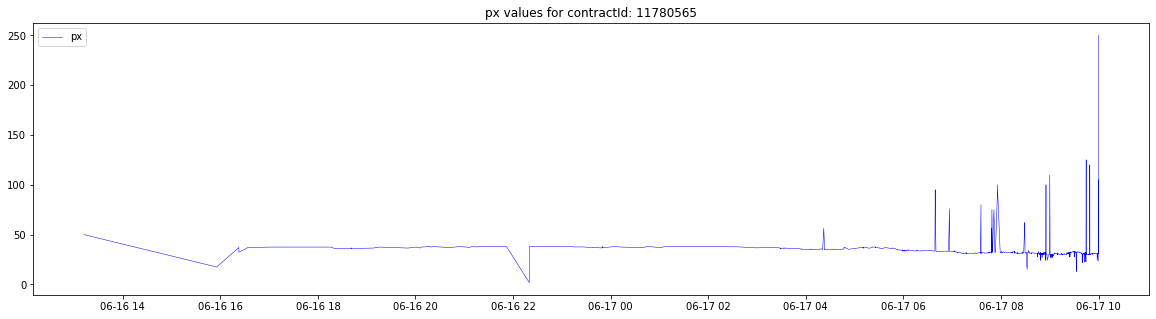

In [ ]:
# Plot the trading price "px" in the original data set (before OHLC calculation)
plt.figure(figsize=(20, 5))
plt.plot(original_df['px'][original_df['contractId']==11780565], label="px", linewidth=0.5, color='blue')
plt.title('px values for contractId: 11780565')
plt.legend(loc="best")

How to read x-axis: 06-16 14 => mm-dd hour

We can see that the trading price jumped in the last hour for this contract which is not supported by the previous trend. It may be difficult for the learing algorithms to predict this jump in the price.

We did the same process for other contracts that show abnormal spikes in the closing prices. It's only because there was jump in the price during or at the end of a particular trading hour that we end up as abnormal spikes in closing prices. That is why we thought of adding hours as a column in our dataset. 

In [ ]:
# insert the trading hour for each trade. 
ohlc_df['hour'] = ohlc_df.index.hour

The hypothesis behind putting weekday is that on work days from Monday to Friday the consumption of Electricity would be more as all the offices are open and frequency of public transport is more while on the weekend most of the people just stay at home.

In [ ]:
# Get the day of the week
ohlc_df['day'] = ohlc_df.index.weekday

In [ ]:
ohlc_df.head(5)

open   high    low  ...  contractId  hour  day
Datetime                                  ...                       
2020-03-01 11:00:00  -0.99  -0.99  -1.00  ...    11629792    11    6
2020-03-01 11:00:00   1.30   1.71   1.30  ...    11629866    11    6
2020-03-01 12:00:00   1.71  18.00  -5.57  ...    11629866    12    6
2020-03-01 11:00:00  18.50  18.50  18.50  ...    11629920    11    6
2020-03-01 12:00:00  18.11  19.00  16.21  ...    11629920    12    6

[5 rows x 11 columns]

For day, 6 is Sunday and 0 is Monday.

We need to One hot encode day of the week, as its categorical. If we don't do one-hot encoding then the algorithm may become bias towards the number.

In [ ]:
# check how many datapoints we have for each day
ohlc_df['day'].value_counts()

0    9671
6    9181
1    9173
3    9076
2    8830
4    8788
5    8732
Name: day, dtype: int64

In [ ]:
# Get one hot encoding of column day
one_hot = pd.get_dummies(ohlc_df.day)
# Drop column day as it is now encoded
ohlc_df = ohlc_df.drop('day',axis = 1)
# Join the encoded df
ohlc_df = pd.concat([ohlc_df, one_hot], axis=1)
ohlc_df

open   high    low  close  open_qty  ...  2  3  4  5  6
Datetime                                                   ...               
2020-03-01 11:00:00  -0.99  -0.99  -1.00  -1.00       0.5  ...  0  0  0  0  1
2020-03-01 11:00:00   1.30   1.71   1.30   1.41       6.0  ...  0  0  0  0  1
2020-03-01 12:00:00   1.71  18.00  -5.57  -5.57       0.5  ...  0  0  0  0  1
2020-03-01 11:00:00  18.50  18.50  18.50  18.50       1.0  ...  0  0  0  0  1
2020-03-01 12:00:00  18.11  19.00  16.21  17.20       1.0  ...  0  0  0  0  1
...                    ...    ...    ...    ...       ...  ... .. .. .. .. ..
2020-08-25 07:00:00  35.00  50.55   5.00  38.53       1.0  ...  0  0  0  0  0
2020-08-24 19:00:00  38.95  38.95  38.95  38.95       4.5  ...  0  0  0  0  0
2020-08-24 20:00:00  38.95  38.95  38.95  38.95      10.5  ...  0  0  0  0  0
2020-08-24 19:00:00  34.95  34.95  34.95  34.95      11.0  ...  0  0  0  0  0
2020-08-24 20:00:00  37.98  37.98  37.98  37.98      52.5  ...  0  0  0  0  0

[63451 rows x 17 columns]

In [ ]:
# give name to the one hot encoded days of the week
ohlc_df.rename(columns = {0:'monday', 1:'tuesday', 2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday', 6:'sunday'}, inplace = True) 

We believe weekend also play an important role in electricity trading, so we add a weekend column too. 

In [ ]:
# create a new column "weekend" put 1 whenever it was Saturday or Sunday.
ohlc_df.loc[ohlc_df['saturday'] == 1, 'weekend'] = 1
ohlc_df.loc[ohlc_df['sunday'] == 1, 'weekend'] = 1

# fill in the null values as 0 for weekdays
ohlc_df = ohlc_df.fillna(0)

In [ ]:
ohlc_px_weekend = ohlc_df[['open', 'high', 'low', 'close']][ohlc_df['weekend']==1.0]
ohlc_px_weekday = ohlc_df[['open', 'high', 'low', 'close']][ohlc_df['weekend']==0.0]

Text(0.5, 1.0, 'OHLC_values for weekend')

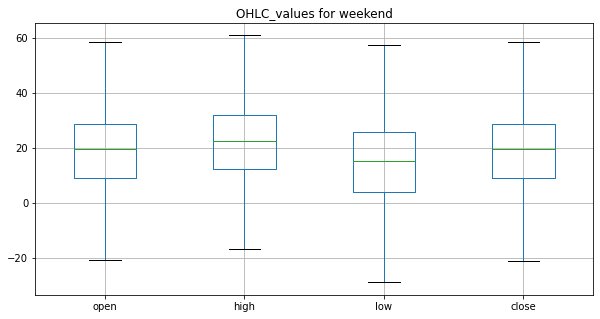

In [ ]:
boxplot_weekend = ohlc_px_weekend.boxplot(figsize=(10, 5), showfliers=False)
plt.title('OHLC_values for weekend')

Text(0.5, 1.0, 'OHLC_values for weekday')

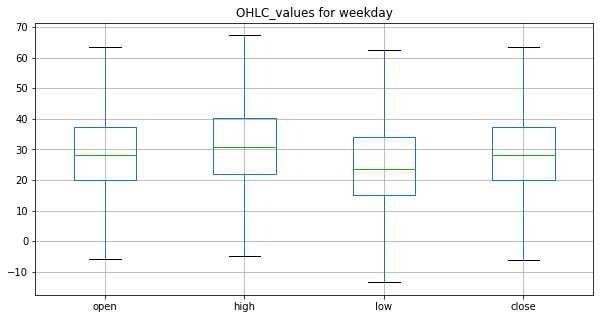

In [ ]:
boxplot_weekday = ohlc_px_weekday.boxplot(figsize=(10, 5), showfliers=False)
plt.title('OHLC_values for weekday')

We can see the price of electricity is higher for weekdays in comparison to weekends. Hence, we include weekend feature in dataset.

**Effects of standard deviation of OHLC values of px on closing price**

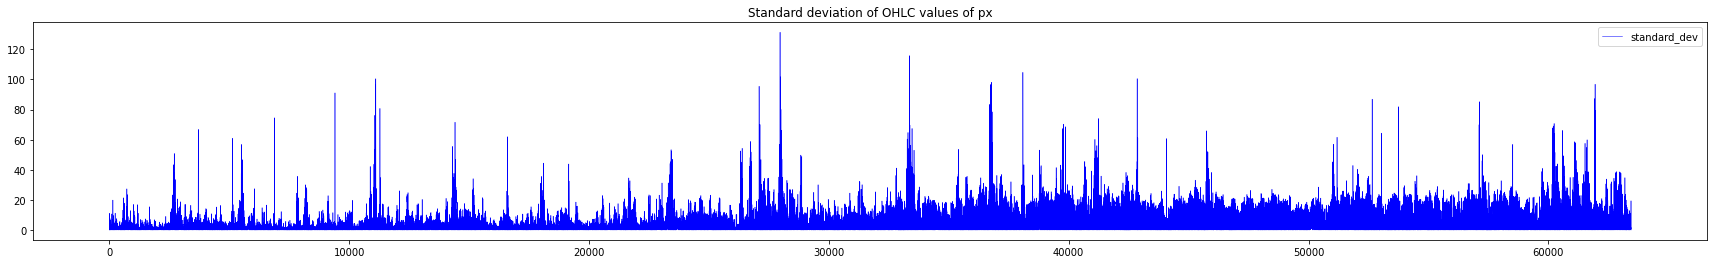

In [ ]:
temp = pd.DataFrame()
temp = ohlc_df[['open', 'high', 'low', 'close']]
x = temp.std(axis=1, skipna=None, level=None, ddof=1, numeric_only=None)
x.reset_index(drop=True, inplace=True)

# Plot the standard_dev of OHLC values for 'px'
plt.figure(figsize=(30, 4))
plt.plot(x, label="standard_dev", linewidth=0.5, color='blue')
plt.title('Standard deviation of OHLC values of px')
plt.legend(loc="best")

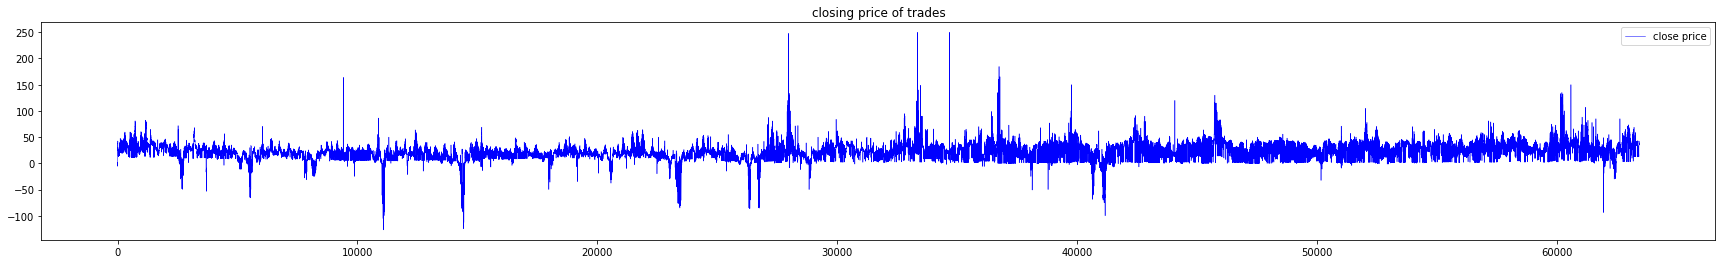

In [ ]:
# Plot the closing price 
ohlc_df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(30, 4))
plt.plot(ohlc_df['close'], label="close price", linewidth=0.5, color='blue')
plt.title('closing price of trades')
plt.legend(loc="best")

Whenever the St. dev of OHLC values of px goes up, closing price is either going -ve or +ve steeply, we include st. dev of OHLC of px in our feature sapce. It made sense to put St. Dev as a column because price is fluctuating alot from low to high in some cases. 

In [ ]:
ohlc_df['Std_Dev_OHLC_px'] = x
ohlc_df 

open   high    low  close  ...  saturday  sunday  weekend  Std_Dev_OHLC_px
0      -0.99  -0.99  -1.00  -1.00  ...         0       1      1.0         0.005774
1       1.30   1.71   1.30   1.41  ...         0       1      1.0         0.193735
2       1.71  18.00  -5.57  -5.57  ...         0       1      1.0        11.114745
3      18.50  18.50  18.50  18.50  ...         0       1      1.0         0.000000
4      18.11  19.00  16.21  17.20  ...         0       1      1.0         1.198416
...      ...    ...    ...    ...  ...       ...     ...      ...              ...
63446  35.00  50.55   5.00  38.53  ...         0       0      0.0        19.360198
63447  38.95  38.95  38.95  38.95  ...         0       0      0.0         0.000000
63448  38.95  38.95  38.95  38.95  ...         0       0      0.0         0.000000
63449  34.95  34.95  34.95  34.95  ...         0       0      0.0         0.000000
63450  37.98  37.98  37.98  37.98  ...         0       0      0.0         0.000000

[63451 rows x 19 columns]

**Effects of standard deviation of OHLC values of qty on closing price**

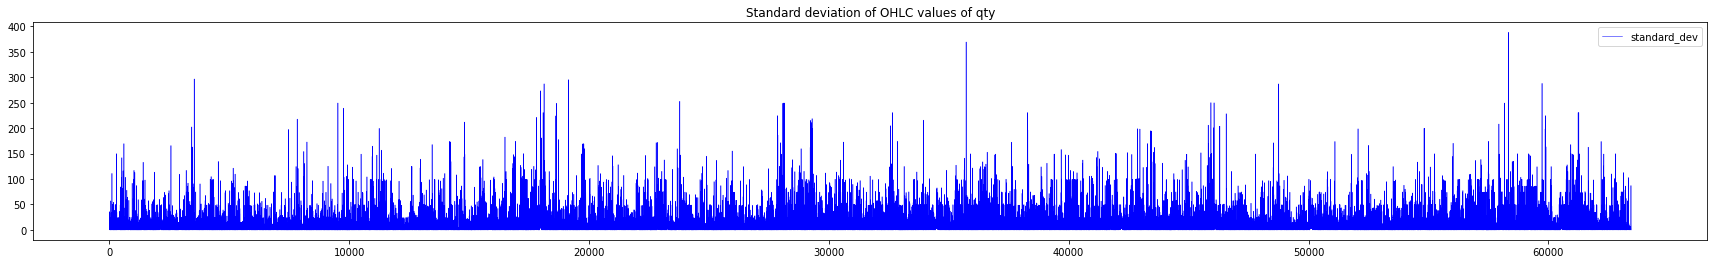

In [ ]:
temp_2 = pd.DataFrame()
temp_2 = ohlc_df[['open_qty', 'high_qty', 'low_qty', 'close_qty']]
x_1 = temp_2.std(axis=1, skipna=None, level=None, ddof=1, numeric_only=None)
x_1.reset_index(drop=True, inplace=True)

# Plot the standard_dev of OHLC values for 'px'
plt.figure(figsize=(30, 4))
plt.plot(x_1, label="standard_dev", linewidth=0.5, color='blue')
plt.title('Standard deviation of OHLC values of qty')
plt.legend(loc="best")

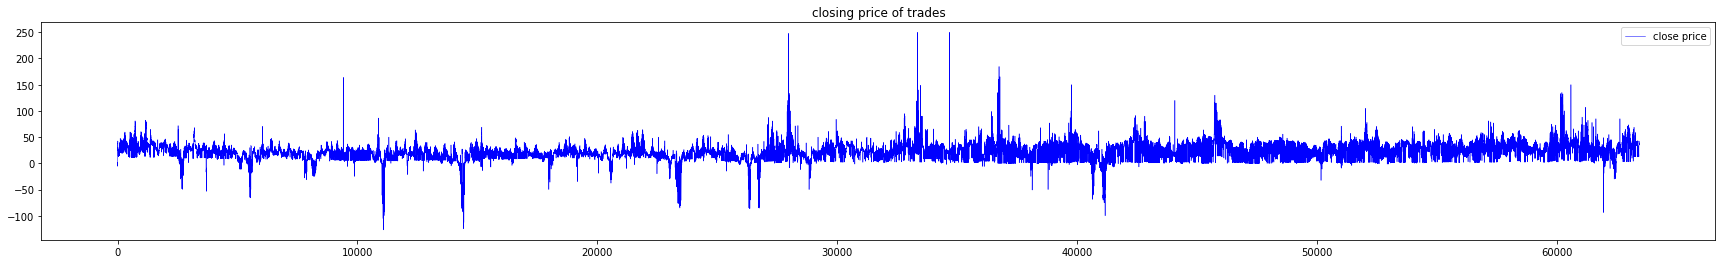

In [ ]:
# Plot the closing price 
ohlc_df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(30, 4))
plt.plot(ohlc_df['close'], label="close price", linewidth=0.5, color='blue')
plt.title('closing price of trades')
plt.legend(loc="best")

In [ ]:
ohlc_df['Std_Dev_OHLC_qty'] = x_1

The idea behind this is to capture the deviation in the OHLC values of quantity w.r.t closing price of that hour.

**Effects of mean of OHLC values of px on closing price**

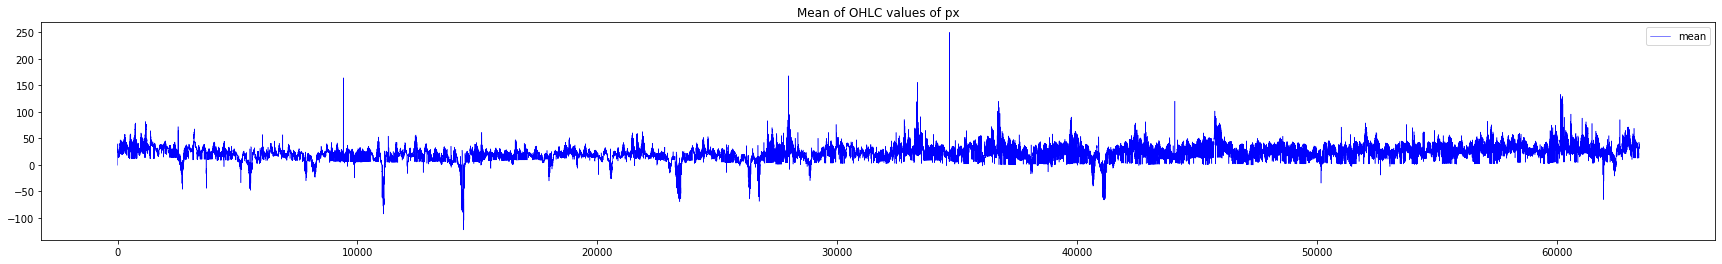

In [ ]:
temp = pd.DataFrame()
temp = ohlc_df[['open', 'high', 'low', 'close']]
x = temp.mean(axis=1, skipna=None, level=None)
x.reset_index(drop=True, inplace=True)

# Plot the standard_dev of OHLC values for 'px'
plt.figure(figsize=(30, 4))
plt.plot(x, label="mean", linewidth=0.5, color='blue')
plt.title('Mean of OHLC values of px')
plt.legend(loc="best")

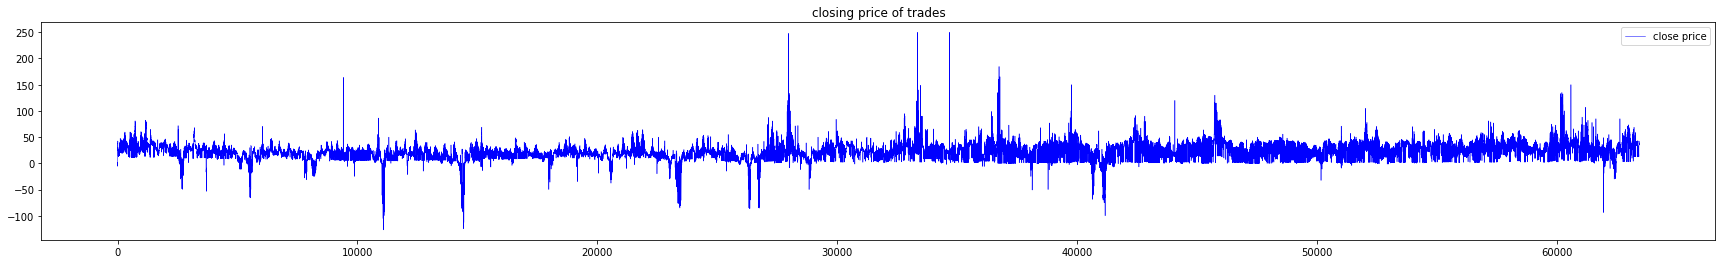

In [ ]:
# Plot the closing price 
ohlc_df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(30, 4))
plt.plot(ohlc_df['close'], label="close price", linewidth=0.5, color='blue')
plt.title('closing price of trades')
plt.legend(loc="best")

Whenever the mean of OHLC values of px goes up, closing price is either going -ve or +ve steeply, we include mean of OHLC of px in our feature sapce. The idea behind this approach is that we should be able to capture the relationship between OHLC values of px.

In [ ]:
ohlc_df['Mean_OHLC_px'] = x

**Adding mean of OHLC values of qty as a feature**

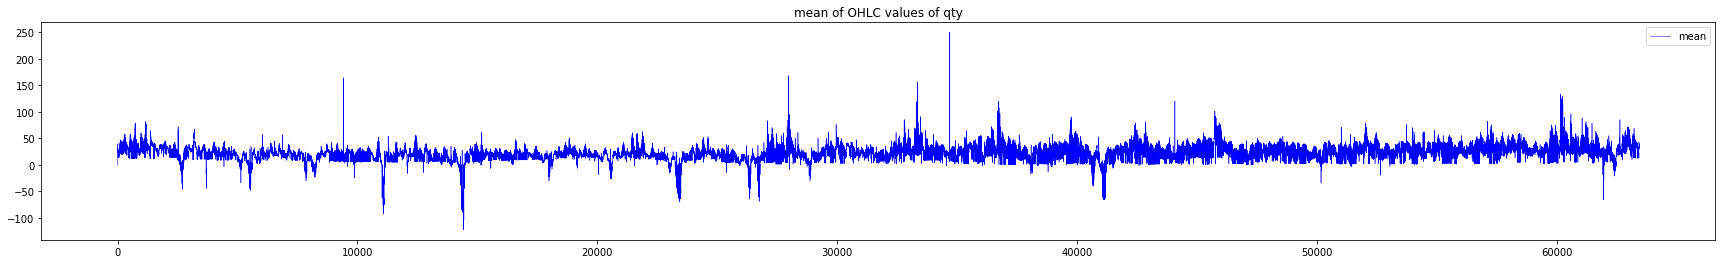

In [ ]:
temp = pd.DataFrame()
temp = ohlc_df[['open_qty', 'high_qty', 'low_qty', 'close_qty']]
x_2 = temp.mean(axis=1, skipna=None, level=None)
x_2.reset_index(drop=True, inplace=True)

# Plot the standard_dev of OHLC values for 'px'
plt.figure(figsize=(30, 4))
plt.plot(x, label="mean", linewidth=0.5, color='blue')
plt.title('mean of OHLC values of qty')
plt.legend(loc="best")

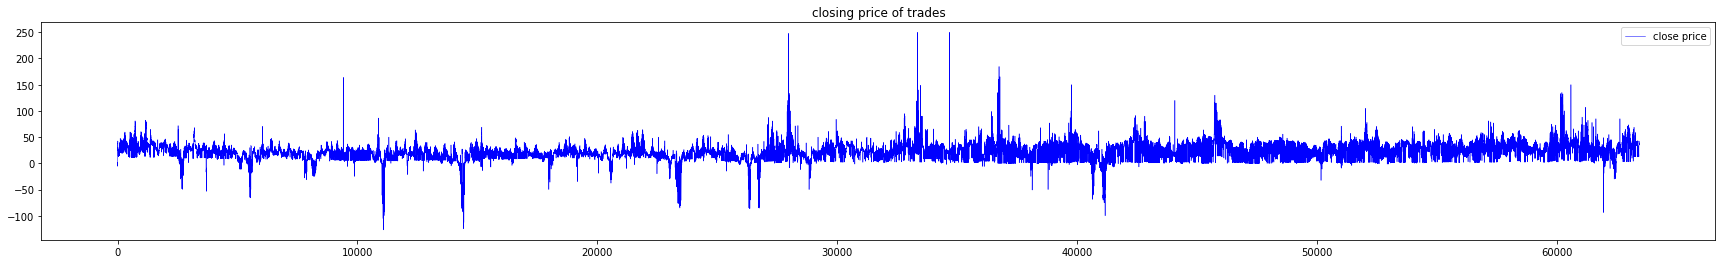

In [ ]:
# Plot the closing price 
ohlc_df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(30, 4))
plt.plot(ohlc_df['close'], label="close price", linewidth=0.5, color='blue')
plt.title('closing price of trades')
plt.legend(loc="best")

In [ ]:
ohlc_df['mean_OHLC_qty'] = x_2

# **Examining Auto Correlations and Partial Autocorrelations to select Window Size**

---



<Figure size 432x288 with 0 Axes>

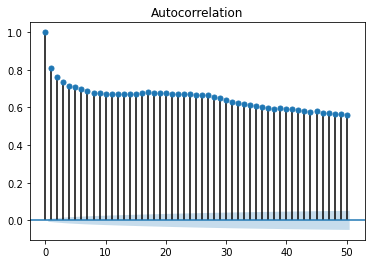

<Figure size 432x288 with 0 Axes>

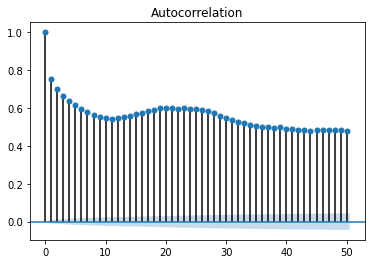

<Figure size 432x288 with 0 Axes>

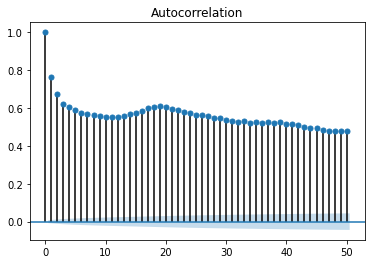

<Figure size 432x288 with 0 Axes>

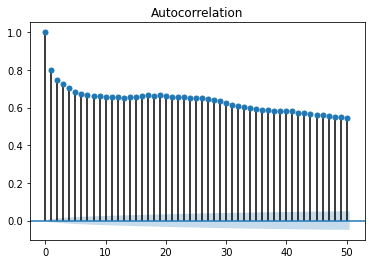

<Figure size 432x288 with 0 Axes>

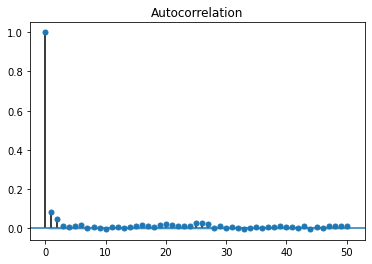

<Figure size 432x288 with 0 Axes>

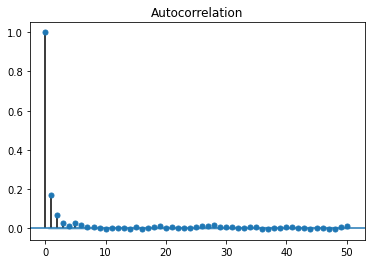

<Figure size 432x288 with 0 Axes>

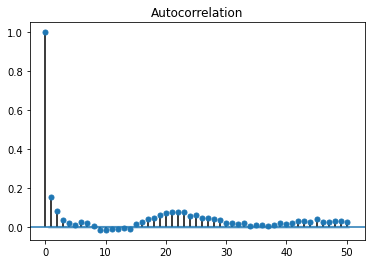

<Figure size 432x288 with 0 Axes>

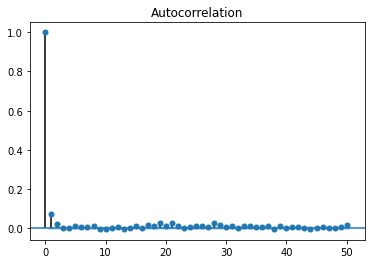

<Figure size 432x288 with 0 Axes>

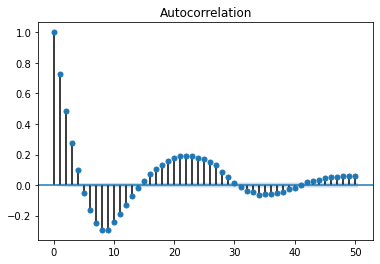

<Figure size 432x288 with 0 Axes>

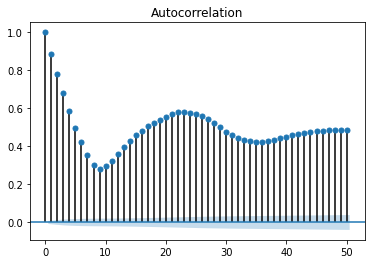

<Figure size 432x288 with 0 Axes>

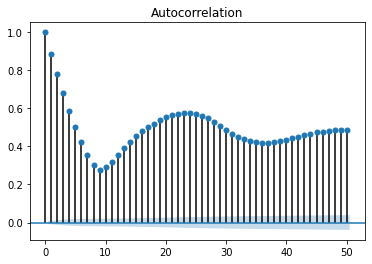

<Figure size 432x288 with 0 Axes>

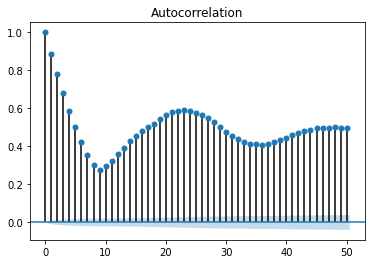

<Figure size 432x288 with 0 Axes>

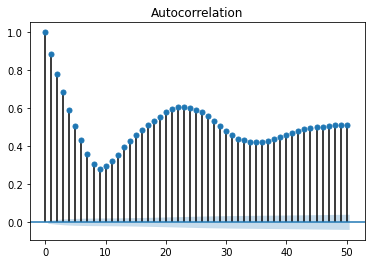

<Figure size 432x288 with 0 Axes>

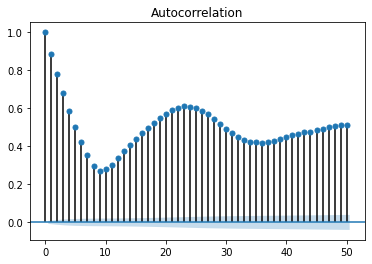

<Figure size 432x288 with 0 Axes>

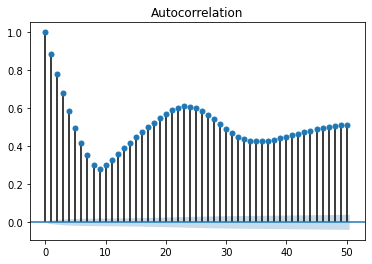

<Figure size 432x288 with 0 Axes>

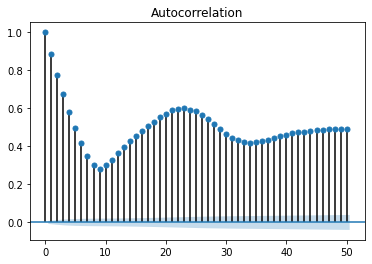

<Figure size 432x288 with 0 Axes>

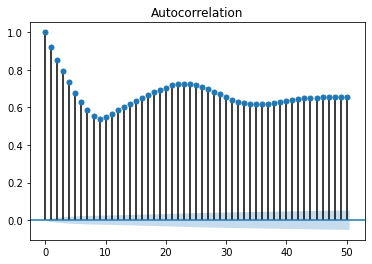

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#columns = [] #use this for speedup
columns = ["open","low","high","close", "open_qty","low_qty","high_qty","close_qty","hour","monday","tuesday","wednesday","thursday","friday","saturday","sunday","weekend"]

for col in columns:
    plt.figure()
    plot_acf(ohlc_df[col].dropna(), lags=50)
    
plt.show()

<Figure size 432x288 with 0 Axes>

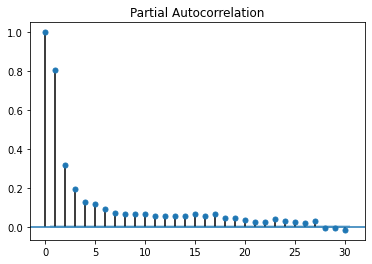

<Figure size 432x288 with 0 Axes>

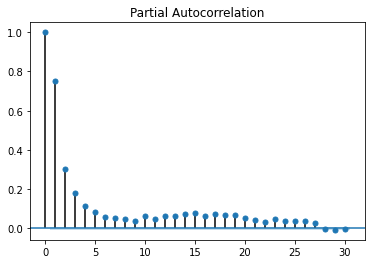

<Figure size 432x288 with 0 Axes>

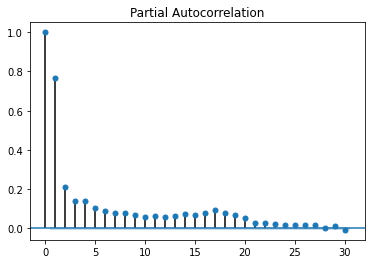

<Figure size 432x288 with 0 Axes>

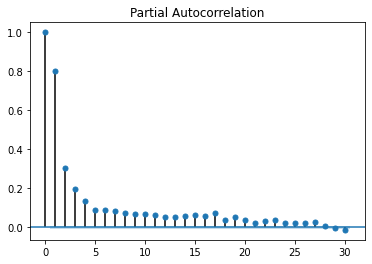

<Figure size 432x288 with 0 Axes>

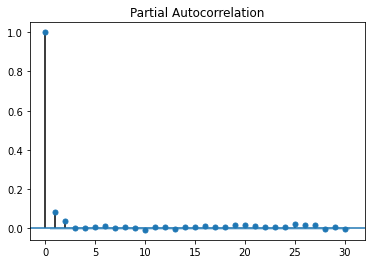

<Figure size 432x288 with 0 Axes>

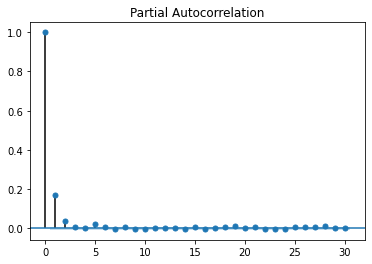

<Figure size 432x288 with 0 Axes>

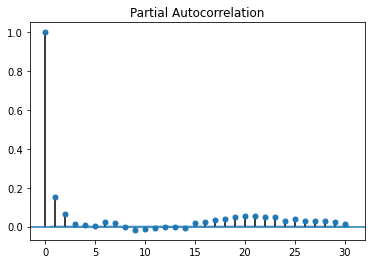

<Figure size 432x288 with 0 Axes>

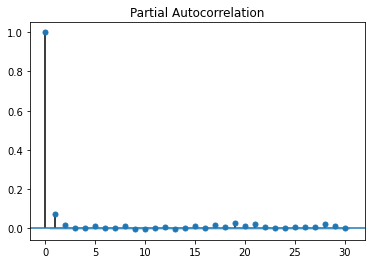

<Figure size 432x288 with 0 Axes>

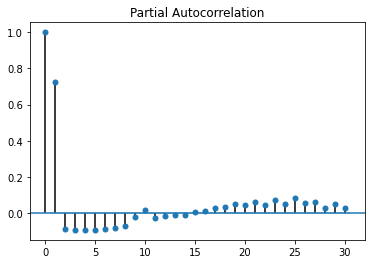

<Figure size 432x288 with 0 Axes>

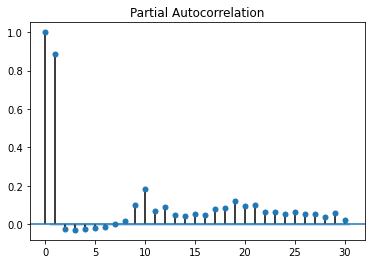

<Figure size 432x288 with 0 Axes>

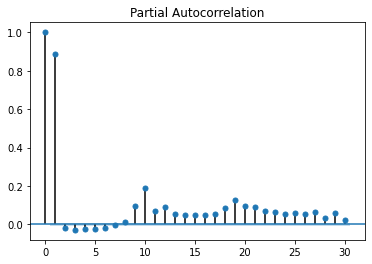

<Figure size 432x288 with 0 Axes>

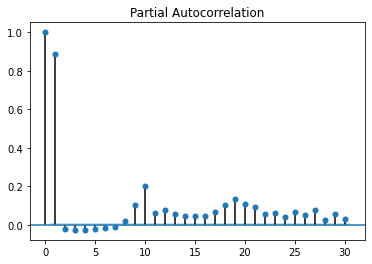

<Figure size 432x288 with 0 Axes>

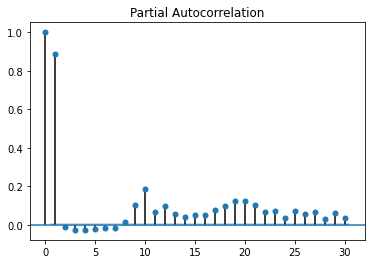

<Figure size 432x288 with 0 Axes>

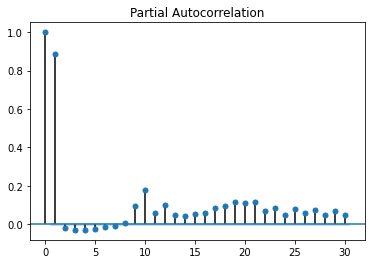

<Figure size 432x288 with 0 Axes>

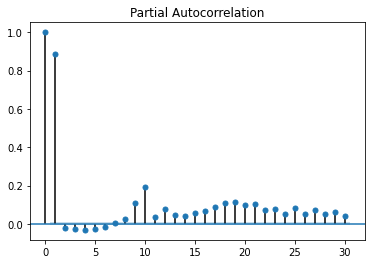

<Figure size 432x288 with 0 Axes>

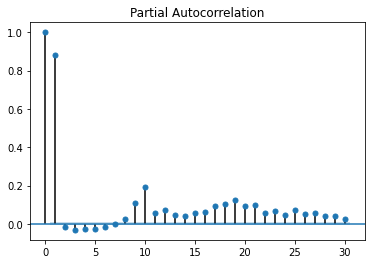

<Figure size 432x288 with 0 Axes>

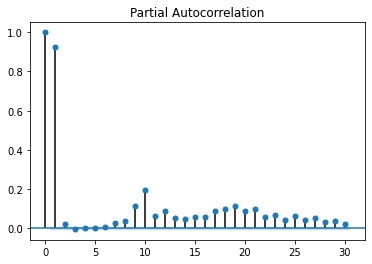

In [ ]:
columns = ["open","low","high","close", "open_qty","low_qty","high_qty","close_qty","hour","monday","tuesday","wednesday","thursday","friday","saturday","sunday","weekend"]

for col in columns:
    plt.figure()
    plot_pacf(ohlc_df[col].dropna(), lags=30)
    
plt.show()

### The partial autocorrelation plots appears to suggest that we stick with a window size of 1 hour. Though it is statistically signficant, the partial autocorrelation after lag of one drops significantly. 

# **Rolling Windows**

---



In [ ]:
# importing the necessary library 
from seglearn.transform import FeatureRep, SegmentXYForecast, last

#### Define window size and forecast distance 

In [ ]:
window_size = 1
forecast_distance = 1

In [ ]:
error_cids = pd.DataFrame()

In [ ]:
y_train_r = []
cid_list=[]

In [ ]:
uniques = ohlc_df['contractId'].unique()

In [ ]:
train_df = pd.DataFrame()

In [ ]:
for cid in uniques:
  X_train = ohlc_df[ohlc_df['contractId']==cid]
  
  segmenter = SegmentXYForecast(width=window_size, step=1, y_func=last, forecast=forecast_distance)

  if X_train.shape[0] < window_size+forecast_distance:
    error_cids['cid'] = X_train.shape[0]
  else:
    # Selecting the y colum
    predict_column='close'
    y_train = X_train[predict_column]
    # Making a windowed version of the data with seglearn segmenter
    X_train_rolled, y_train_rolled, _= segmenter.fit_transform([X_train.drop(labels=['contractId'], axis=1).values],[y_train.values.flatten()])
    
    y_train_r.append(y_train_rolled)
    
    # getting the segmented indices, aka dates
    X_train_index_rolled, _, _ = segmenter.fit_transform([X_train.drop(labels=['contractId'], axis=1).index.values],[y_train.values.flatten()])
    count = 0
    # Iterating through the seglearn output windows (3D arrays)
    for i in X_train_rolled:
        # Flattening X_train_rolled to append as a row to the return df of df_windowing function
        data = pd.Series(i.flatten())
        
        # Appending flattened data
        train_df = train_df.append(data, ignore_index=True)
        cid_list.append(cid)

        # Appending y values from the y_train_rolled to the last added window row
    #train_df['y']= y_train_rolled
train_df['contractId'] = cid_list
train_df['y'] = [inner_item for item in y_train_r for inner_item in item]

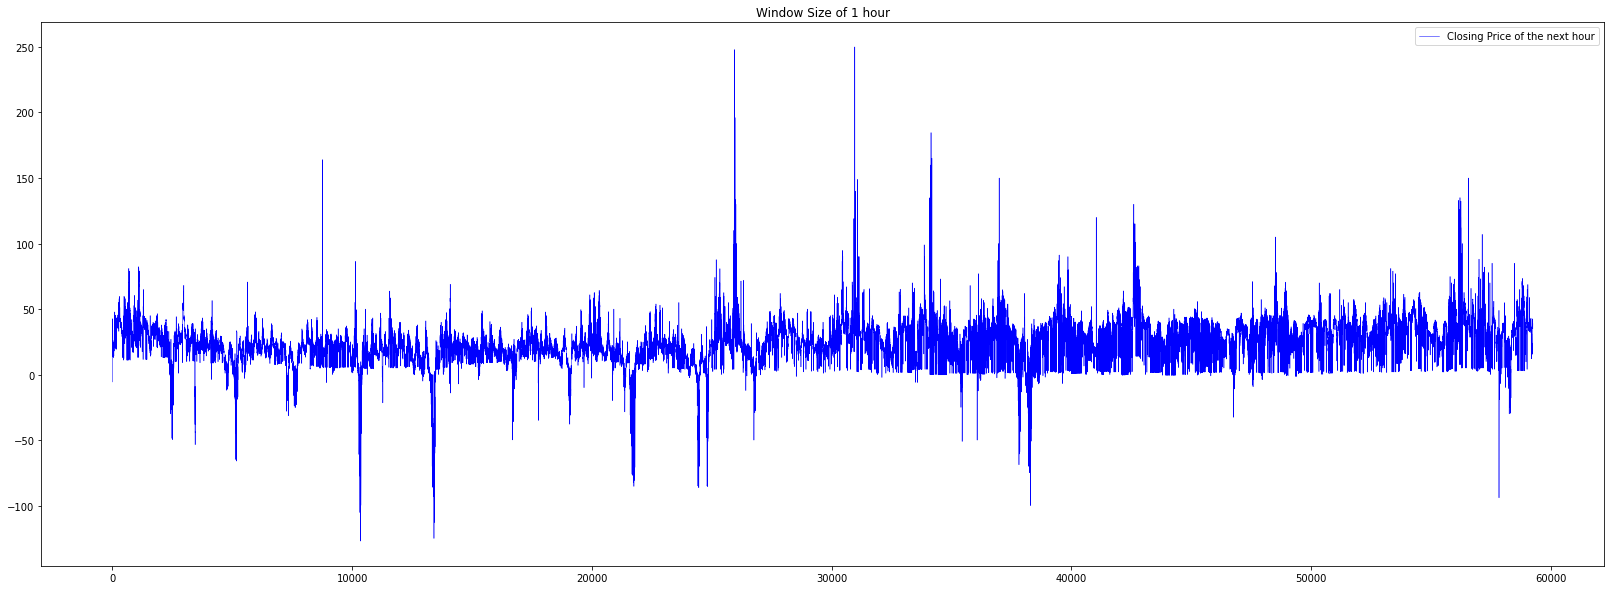

In [ ]:
# Plot the true values for the target variable y which is "closing priceof the next hour"
plt.figure(figsize=(28, 10))
plt.plot(train_df['y'], label="Closing Price of the next hour", linewidth=0.5, color='blue')
plt.title('Window Size of 1 hour')
plt.legend(loc="best")

To evaluate our models we will use "Mean Absolute Error" as a loss function that gives equal weightage to large and small errors. Since we have a lot of fluctuations we dont want our model to penalize alot on large errors as in the case of Mean Squared Error.

Although the time series looks stationary we can confirm with the help of Dickey-Fullertest

In [ ]:
# H0: time series is non stationary
# H1: time series in stationary 

from statsmodels.tsa.stattools import adfuller

def adfuller_test(closing_price):
  results = adfuller(closing_price)
  labels = ['ADF test statistic', 'p-value', '#Lags used', 'Number of observations']
  for value, label in zip(results, labels):
    print(label+ ' : '+ str(value))
  if results[1] <= 0.05:
    print('Reject the null hypothesis (H0), Data has no unit root and is stationary')
  else:
    print('Do not reject the null hypothesis (H0), time series has a unit root and is non-stationary')

In [ ]:
adfuller_test(train_df['y'])

ADF test statistic : -12.937823728580735
p-value : 3.586762448027637e-24
#Lags used : 55
Number of observations : 59199
Reject the null hypothesis (H0), Data has no unit root and is stationary


# **Splitting** 

---


We split the data before normalization to avoid information leakage from validation and test set to the train set. 

In [ ]:
# define the split size
# 95% for train set & 5% for test set during first split
# Then out of that 95% train set, 5% validation set

split_size = 0.05

In [ ]:
from sklearn.model_selection import train_test_split


X = train_df.drop(columns=['contractId', 'y'])
y = train_df['y']
 
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, shuffle=False)
# Creating by splitting from remaning data of train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=split_size, shuffle=False)

In [ ]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(53477, 21) (53477,) (2815, 21) (2815,) (2963, 21) (2963,)


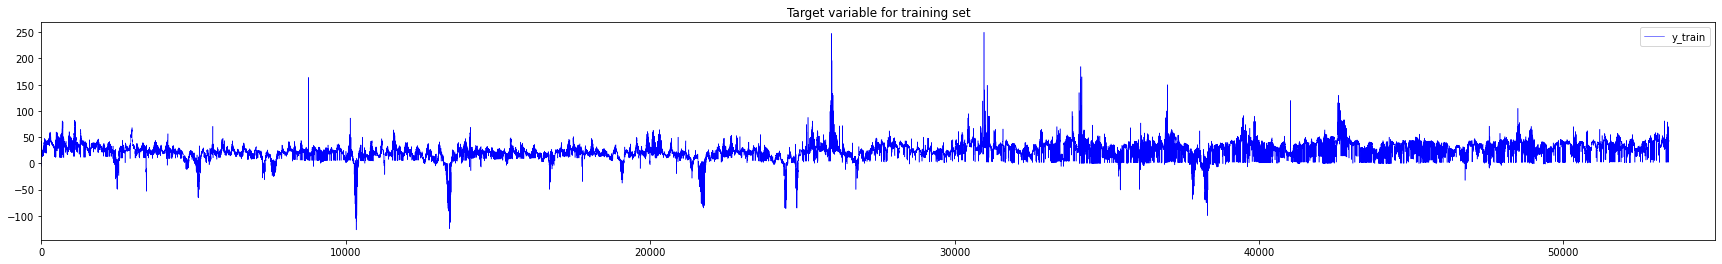

In [ ]:
# visualize the target variable for training set
plt.figure(figsize=(30, 4))
plt.plot(y_train.values, "g", label="y_train", linewidth=0.5, color='blue')
plt.title('Target variable for training set')
plt.xlim(0, 55000)
plt.legend(loc="best")

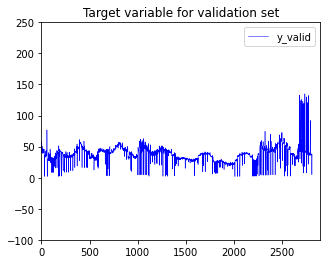

In [ ]:
# visualize the target variable for validation set
plt.figure(figsize=(5, 4))
plt.plot(y_valid.values, "g",label="y_valid",linewidth=0.5, color='blue')
plt.title('Target variable for validation set')
plt.ylim(-100, 250)
plt.xlim(0, 2900)
plt.legend(loc="best")

We have spikes going above 100 in validation set (difficult to predict those).

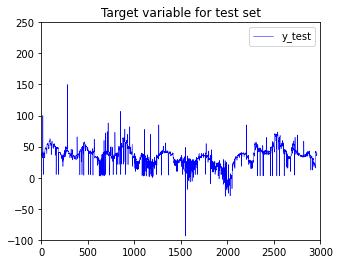

In [ ]:
# visualize the target variable for test set
plt.figure(figsize=(5, 4))
plt.plot(y_test.values, "g", label="y_test",linewidth=0.5, color='blue')
plt.title('Target variable for test set')
plt.ylim(-100, 250)
plt.xlim(0, 3000)
plt.legend(loc="best")

# **Normalize**

---



#### Normalized data produced slightly better results for Deeplearning Algorithms. Cost function is not stretched due to different range of values of our features and gradient decent can take much larger steps.

####Normalization using MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# define instance of scaler for train/valid/testset
scaler = MinMaxScaler()

# define instance of sclaer for actual values (needed for inverse transformation)
scaler2 = MinMaxScaler()

# fit the scaler on train set
scaler = scaler.fit(X_train)
scaler2 = scaler2.fit(y_train.values.reshape(-1, 1))

# then transform the train set
X_train = scaler.transform(X_train)
y_train = scaler2.transform(y_train.values.reshape(-1, 1))

# then transform the valid set
X_valid = scaler.transform(X_valid)
y_valid = scaler2.transform(y_valid.values.reshape(-1, 1))

# and finally transform the test set
X_test = scaler.transform(X_test)
y_test = scaler2.transform(y_test.values.reshape(-1, 1))

# **Visualization Helper**

---



We need a visulization helper to plot **predictions** and **actual** values (for train, valid and test sets) on top of each other so that we can make comparisions.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

def plotModelResults(model, X, y, test, valid, train, model_name):
  #Plots modelled vs actual values
  
  if model_name in ('dummy_model','xg_reg','RF_base_model'):
    prediction = model.predict(X)
    prediction = prediction.reshape(-1, 1)

  else:
    prediction = model.predict(X)


  # inverse transform the predictions to original values (unscaled values)
  prediction = scaler2.inverse_transform(prediction)

  # inverse transform the actual values to original values (unscaled values)
  y_inverse = scaler2.inverse_transform(y)

  plt.figure(figsize=(30, 10))
  plt.plot(prediction, "g", label="Prediction", linewidth=1.3, color='red')
  plt.plot(y_inverse, label="Actual", linewidth=1.3, color='Green')
    
  error_mse = mean_squared_error(y_inverse, prediction)
  error_mae = mean_absolute_error(y_inverse, prediction)
  error_rmse = mean_squared_error(y_inverse, prediction, squared=False)

  if test == True:
    plt.title("MSE on Test data {0:.6f}".format(error_mse)+" , "+"MAE = {0:.6f}".format(error_mae)+" & "+"RMSE {0:.6f}".format(error_rmse),  fontsize=20)
  
  elif valid == True:
    plt.title("MSE on validation data = {0:.6f}".format(error_mse)+" , "+"MAE = {0:.6f}".format(error_mae)+" & "+"RMSE = {0:.6f}".format(error_rmse), fontsize=20)
  
  else:
    plt.title("MSE on train data {0:.6f}".format(error_mae)+" , "+"MAE = {0:.6f}".format(error_mae)+" & "+"RMSE = {0:.6f}".format(error_rmse), fontsize=20)

  plt.legend(loc="best")
  plt.tight_layout()
  plt.grid(False)
  return prediction

# **Modelling**

---



First we will create a simple baseline model, it will be a benchmark for us that other models should atleast perform better than this. 

## **Baseline**

---



Our baseline simply predicts the mean of the closing price (target) for train, valid and test set. 

In [ ]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")

dummy_model.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

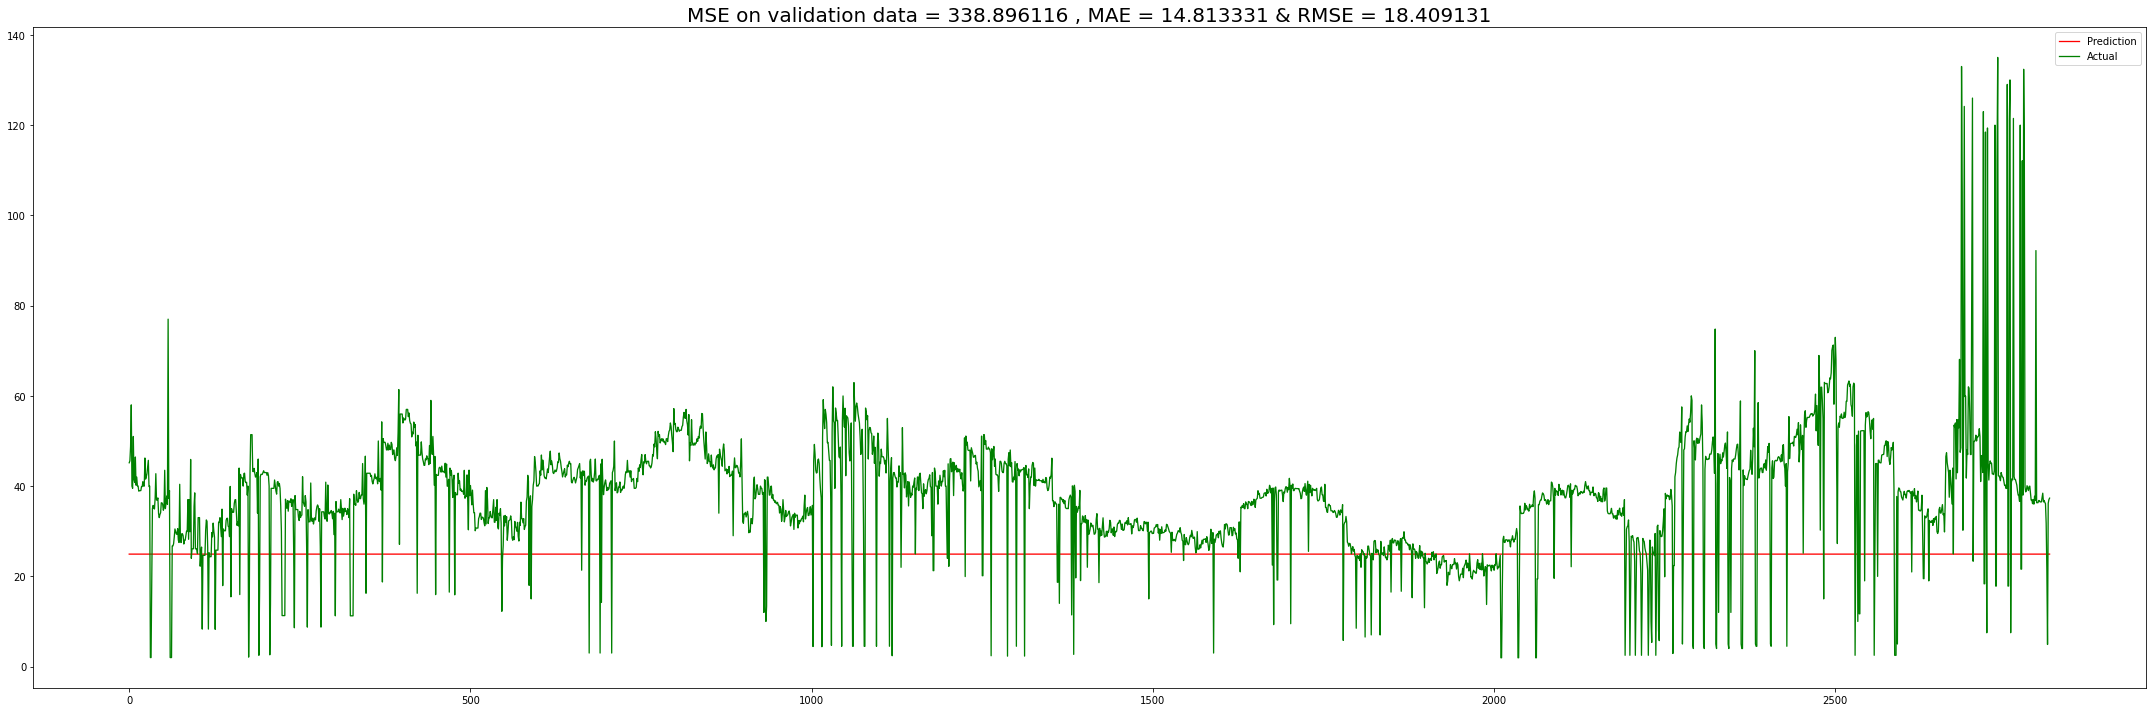

In [ ]:
prediction = plotModelResults(dummy_model, X_valid, y_valid, test=False, valid=True, train=False, model_name='dummy_model')

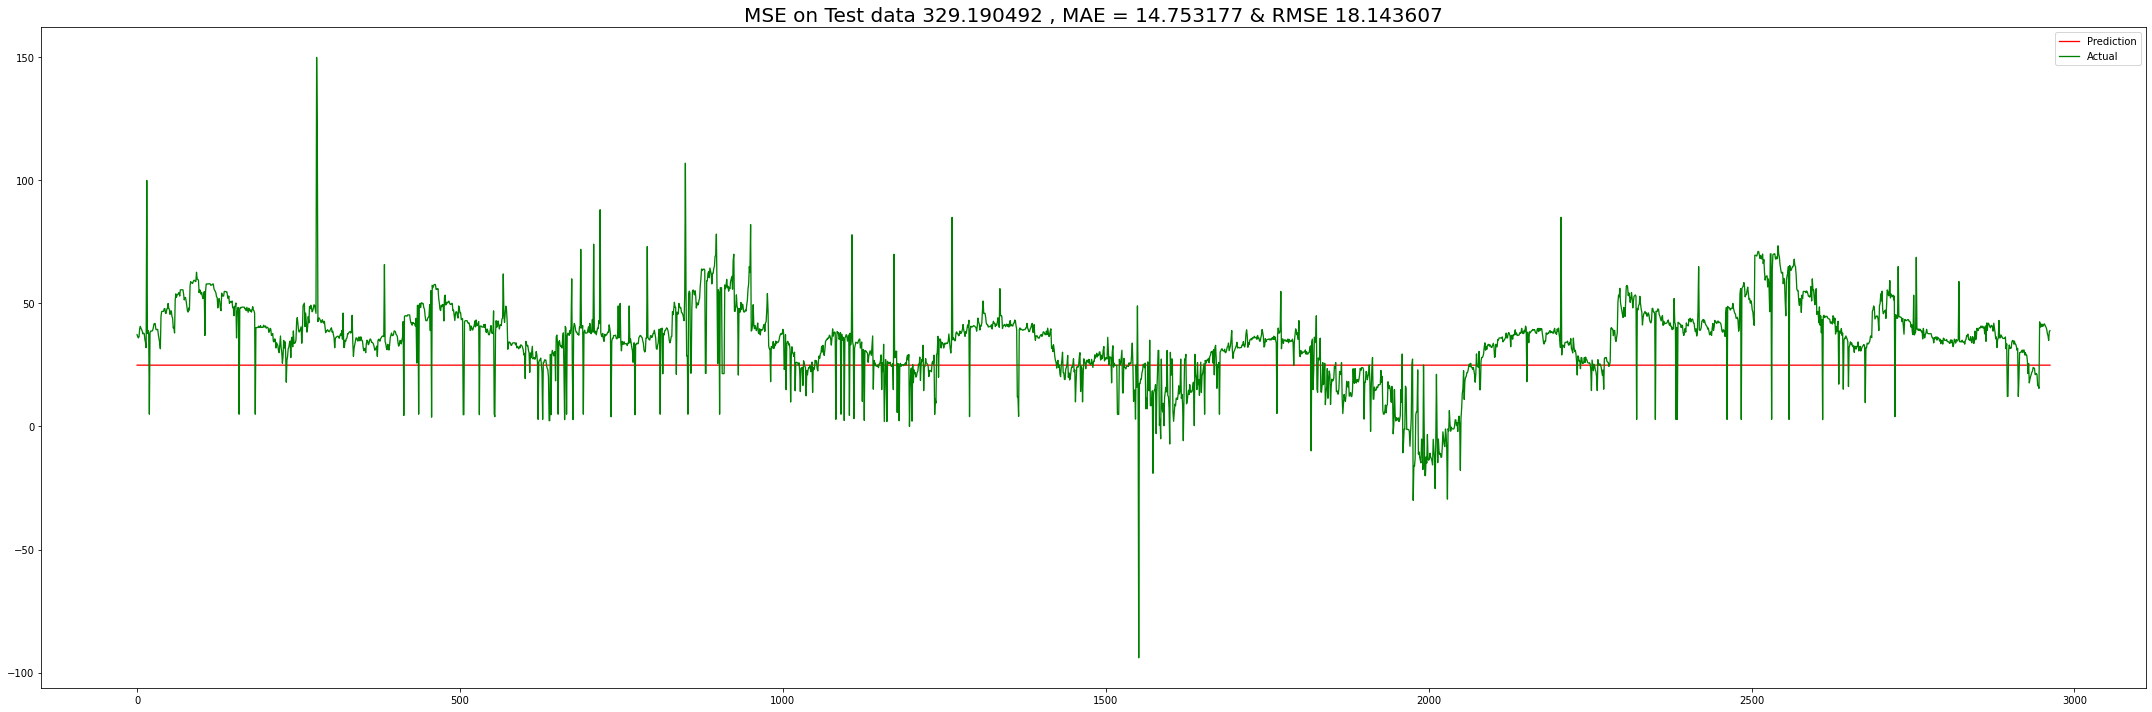

In [ ]:
prediction = plotModelResults(dummy_model, X_test, y_test, test=True, valid=False, train=False, model_name='dummy_model')

Now we have an idea about the upper bound of the errors. We expect our learning models should do alteast better than the baseline. 

## **Traditional Algorithms**

---



### XG_Boost

In [ ]:
import xgboost as xgb

# XGBoost needs it's custom data format to run quickly
dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
dmatrix_valid = xgb.DMatrix(data=X_valid,label=y_valid)
dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)


In [ ]:
params = {'objective': 'reg:linear', 'eval_metric': 'mae', 'n_estimators': 40}

evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]

num_round = 11

xg_reg = xgb.train(params, dmatrix_train, num_boost_round=num_round, evals=(evallist), verbose_eval=True)

[16:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:0.045903	train-mae:0.068558
[1]	eval-mae:0.032857	train-mae:0.048494
[2]	eval-mae:0.024371	train-mae:0.034809
[3]	eval-mae:0.018787	train-mae:0.025543
[4]	eval-mae:0.015498	train-mae:0.0194
[5]	eval-mae:0.013494	train-mae:0.015335
[6]	eval-mae:0.012413	train-mae:0.012787
[7]	eval-mae:0.011803	train-mae:0.011167
[8]	eval-mae:0.011617	train-mae:0.010253
[9]	eval-mae:0.011586	train-mae:0.009776
[10]	eval-mae:0.011554	train-mae:0.009507


Although the train error is lower than validation error, it doesnot mean that model is overfitting. However, after 11 rounds the validation error starts to increase resulting is overfitting so we limit num_rounds to 11. 

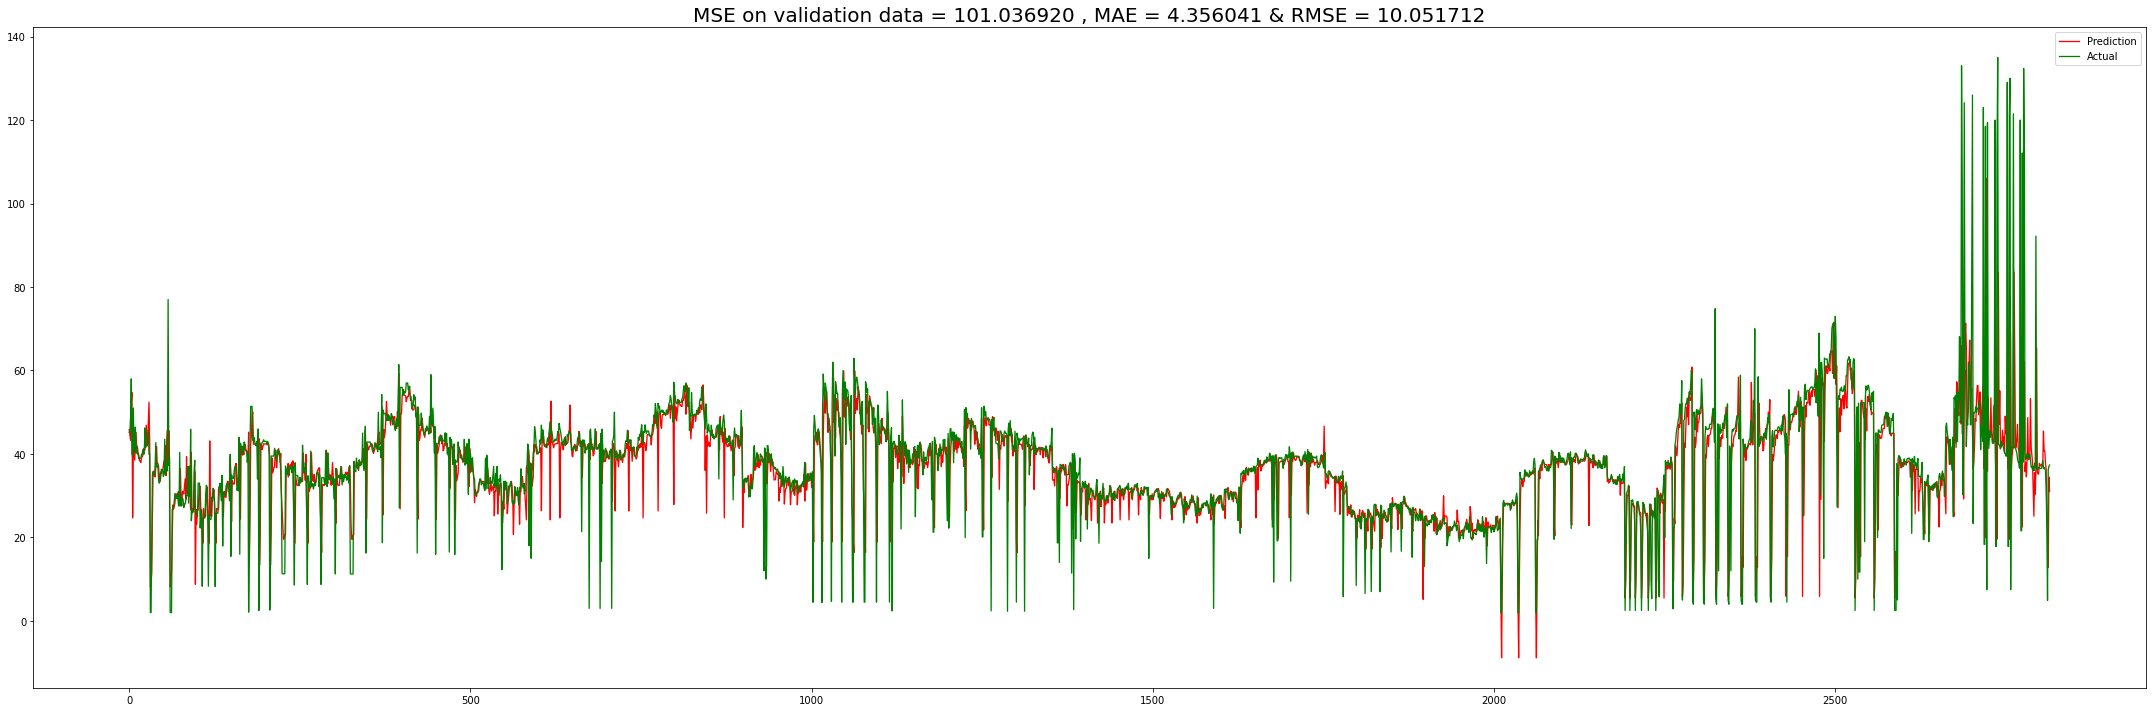

In [ ]:
prediction = plotModelResults(xg_reg, dmatrix_valid, y_valid, test=False, valid=True, train=False, model_name = 'xg_reg')

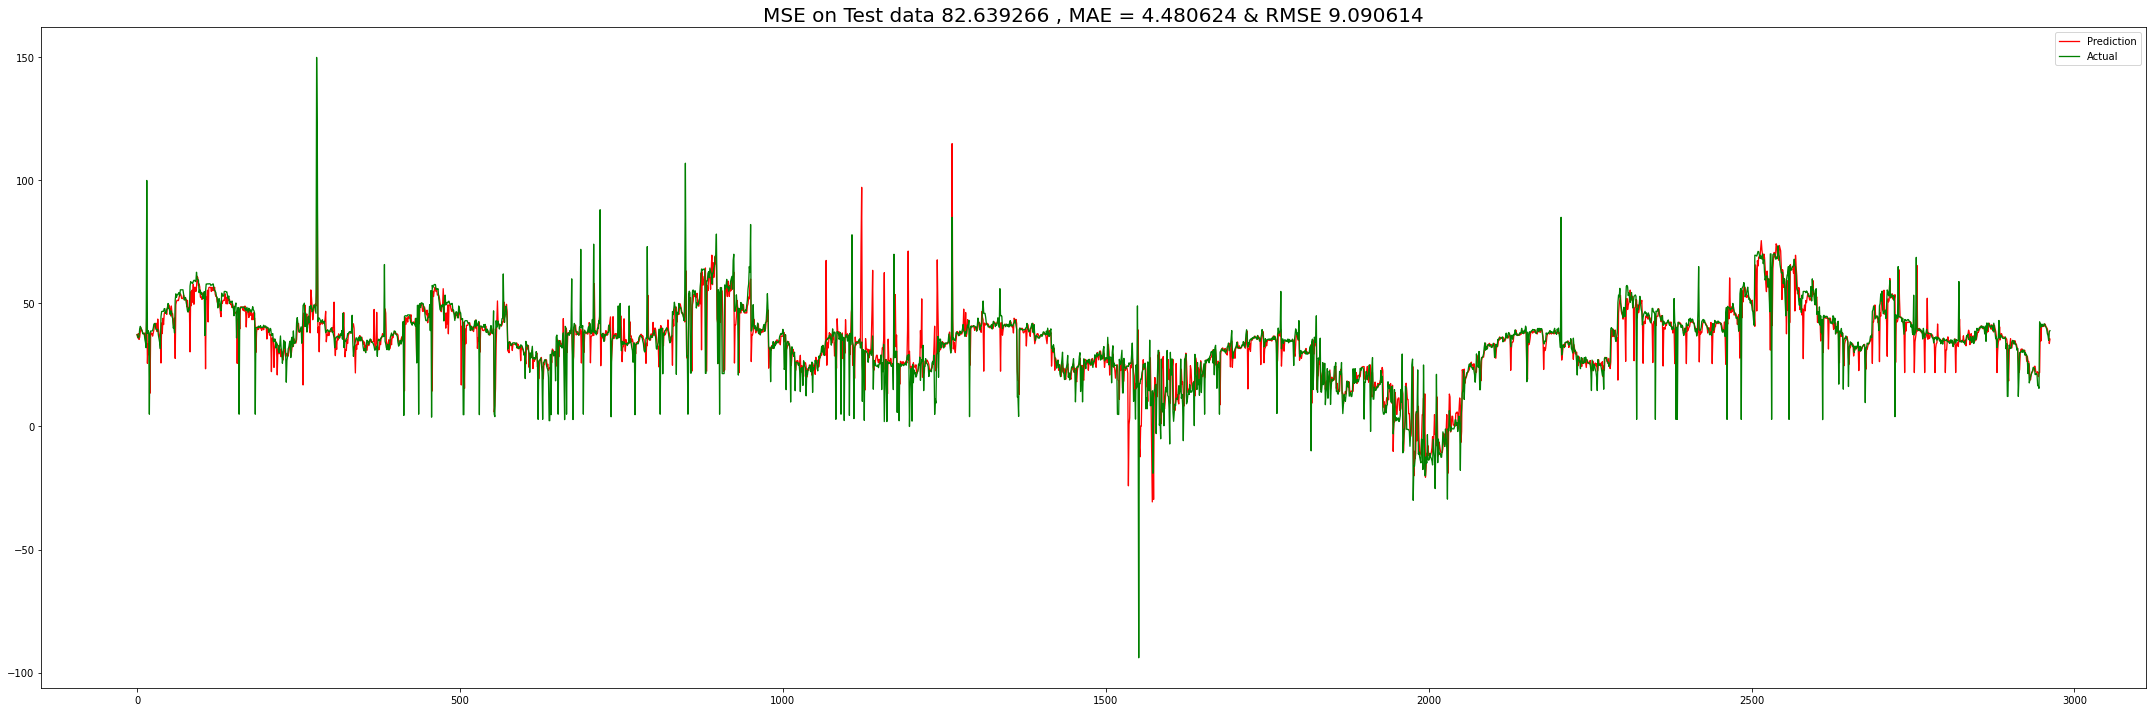

In [ ]:
prediction = plotModelResults(xg_reg, dmatrix_test, y_test, test=True, valid=False, train=False, model_name = 'xg_reg')

### **Random Forest with manual hyperparameter tuning**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 452543634

In [ ]:
RF_base_model =RandomForestRegressor(n_estimators=500, verbose=0,  criterion='mse', max_depth=10 ,random_state=RANDOM_STATE, n_jobs=-1)

RF_base_model.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=452543634, verbose=0, warm_start=False)

If we change the criterion to mean absolute error, it took a lot of time. Why this happenes is still to be discovered. As of now, we stick with Mean Squared Error as criterion.

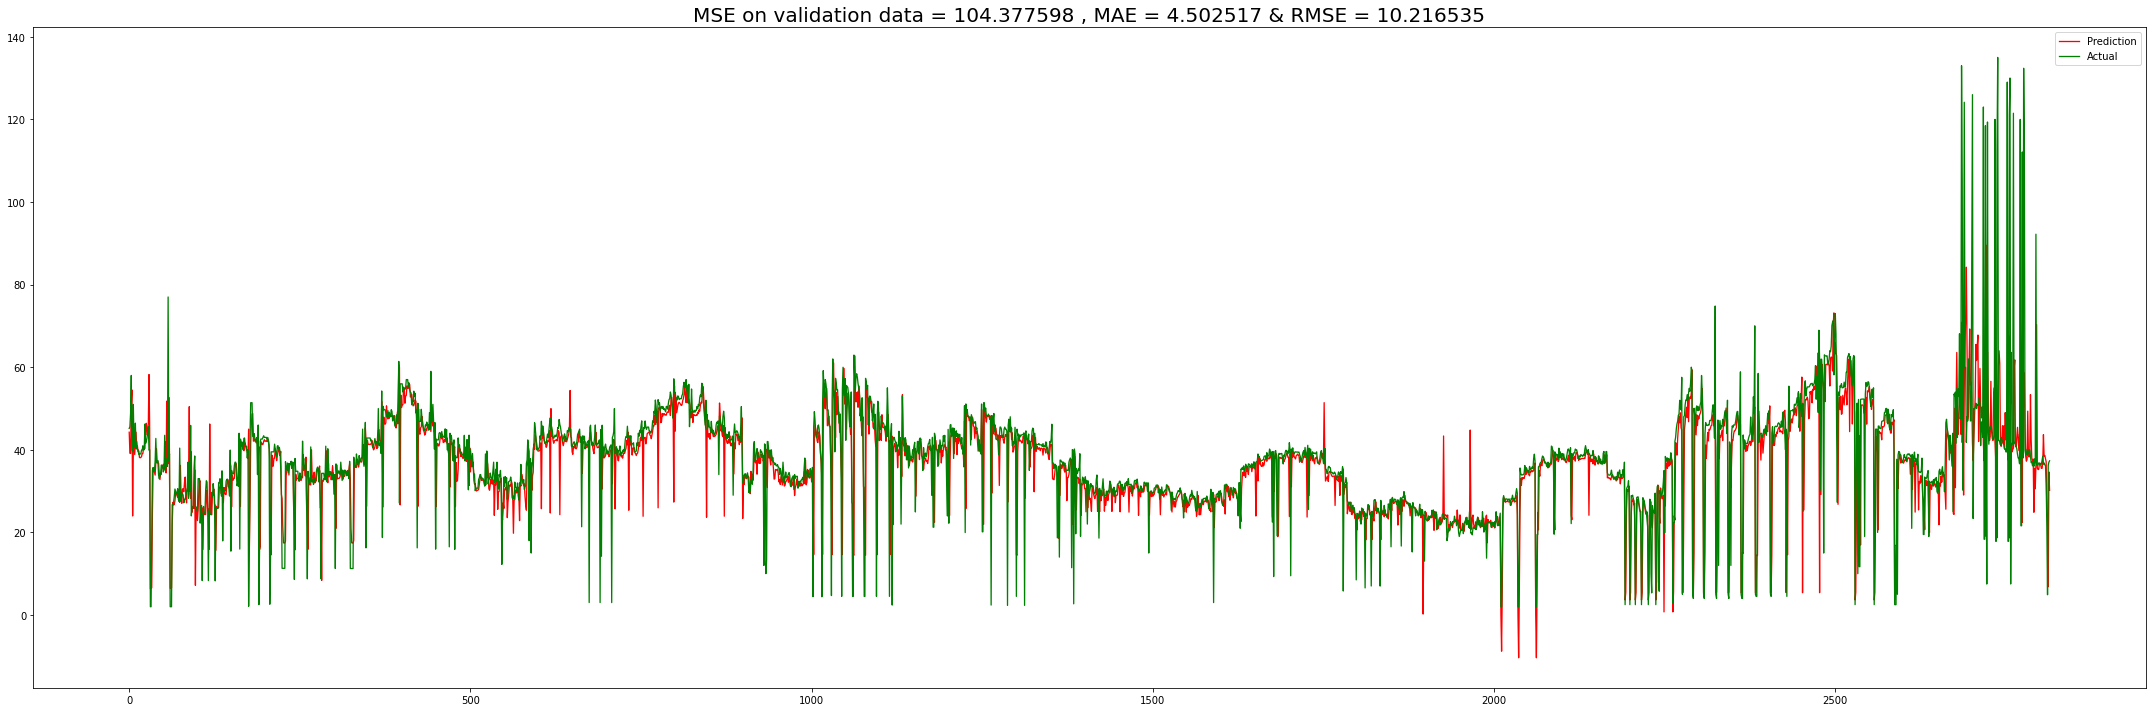

In [ ]:
prediction = plotModelResults(RF_base_model, X_valid, y_valid, test=False, valid=True, train=False, model_name = 'RF_base_model')

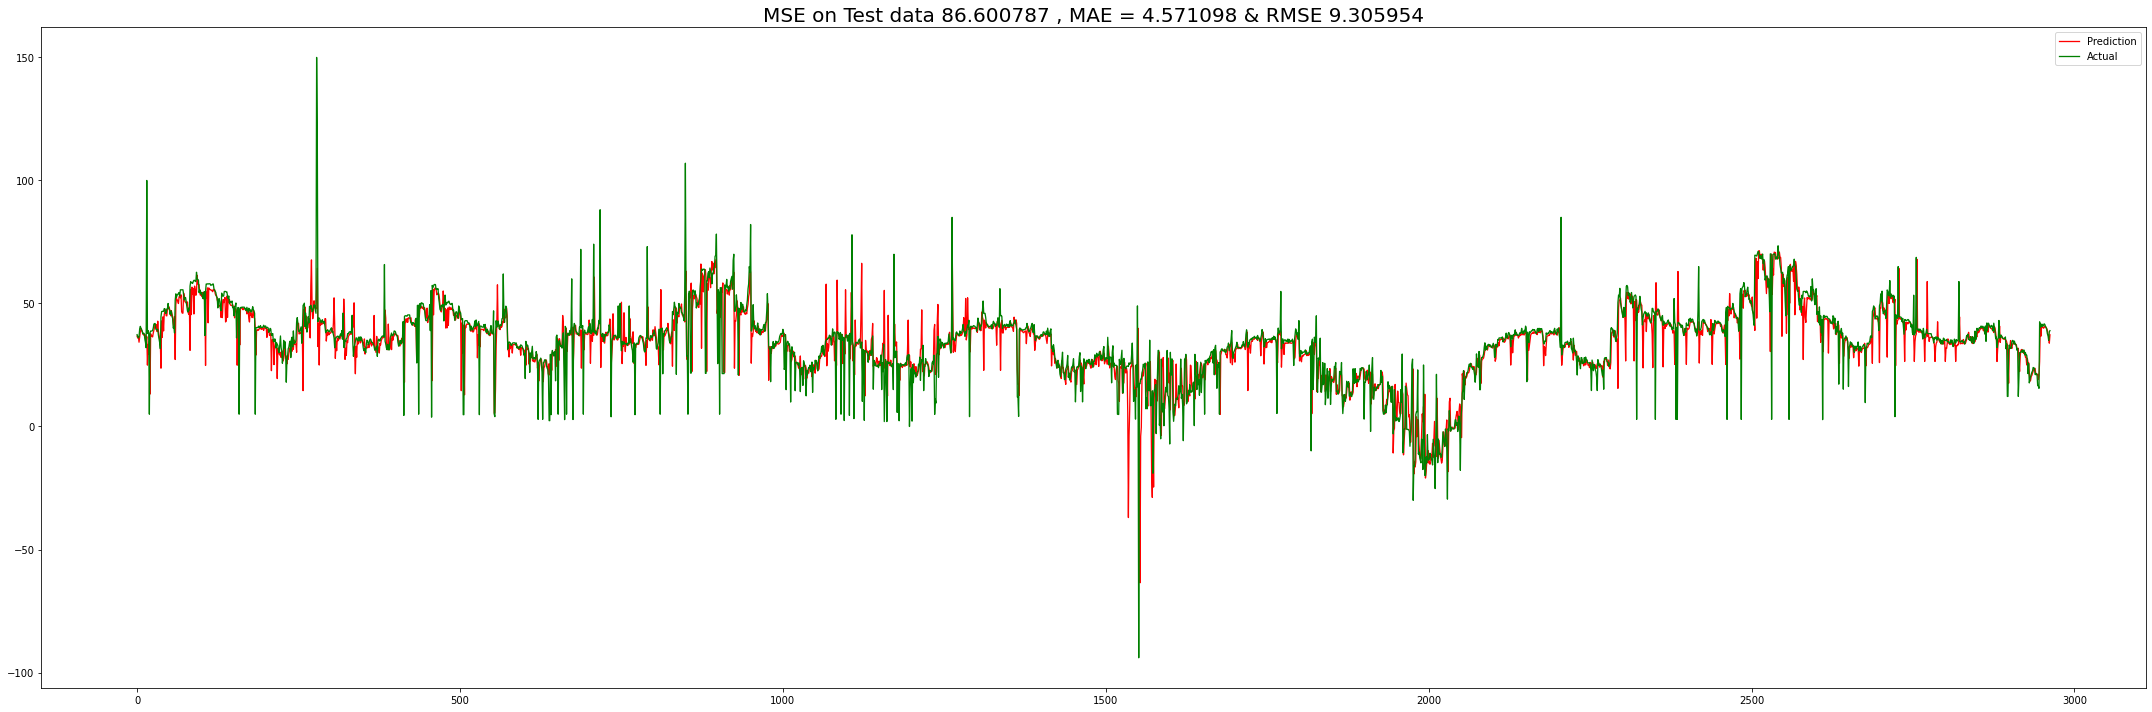

In [ ]:
prediction = plotModelResults(RF_base_model, X_test, y_test, test=True, valid=False, train=False, model_name = 'RF_base_model')

### Let's see if Deeplearning algorithms can learn better than traditional algorithms.

## **Reshaping the data for CNN and LSTM**

---



In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)
print("Test set reshaped", X_test.shape)

Train set reshaped (53477, 21, 1)
Validation set reshaped (2815, 21, 1)
Test set reshaped (2963, 21, 1)


## **Convolutional Neural Network**

---



In [ ]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import regularizers
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from numpy.random import seed
seed(14)
tf.random.set_seed(19)

In [ ]:
print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (53477, 21, 1)
Validation set reshaped (2815, 21, 1)


 **Note:**  We used **Checkpoint callbacks** to save the best weights corresponding to the lowest mean absoulte error on validation data and to  monitor overfitting/underfitting and tuned the hyperparameters after every 5 to 10 epochs.

In [ ]:
# Defining the Hyperparameters
dropout_rate = 0.1
batch_size = 32
epoch_count = 70

#### **Network Architecture**

![](https://drive.google.com/uc?export=view&id=1tQgC-Xxha4aIXrR7KSMWkxUJnviiGUZI)




### Reason to choose the Architecture. 
We started off with a simple model having a single layer and a one filter and evaluate the learning capacity of the model on the given dataset. If the learning capacity is not enough on train set, we increase the number of filters and then again evaluate the performance. Simultaniously, we also check for overfitting.

We limited the filter size to 2 to take the advantage of parameter sharing. 

In [ ]:
tf.compat.v1.reset_default_graph() 
clear_session()          

# Full model

x = Input(shape=(X_train.shape[1],  X_train.shape[2]))


conv1 = Conv1D(300, 2, strides=1, padding='same', activation='relu', kernel_initializer=glorot_normal(seed=19))(x)
Pool1 = MaxPool1D(pool_size=2, strides=1, padding='valid')(conv1)
dropout1 = Dropout(dropout_rate)(Pool1)

conv2 = Conv1D(150, 2, strides=1, padding='same', activation='relu', kernel_initializer=glorot_normal(seed=19))(dropout1)
Pool2 = MaxPool1D(pool_size=2, strides=1, padding='valid')(conv2)
dropout2 = Dropout(dropout_rate)(Pool2)

flatten_1 = Flatten()(dropout2)

Dense1 = Dense(50, activation='relu', kernel_initializer=glorot_normal(seed=19))(flatten_1)
dropout3 = Dropout(dropout_rate)(Dense1)

predictions = Dense(1, activation='linear', kernel_initializer=glorot_normal(seed=19))(dropout3)



# Instantiate (initialize) the model with inputs and outputs
model = Model(x, predictions)

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 300)           900       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 300)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 150)           90150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 150)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 150)          

**Loss, optimization and compilation**

In [ ]:
loss = "mean_absolute_error"
optimizer = Adam(learning_rate= 0.00015)

# Compilation
model.compile(optimizer=optimizer, loss=loss, metrics='RootMeanSquaredError')

**Training**

In [ ]:
checkpoint_filepath = '/cnn/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

#model.load_weights(checkpoint_filepath)


history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=epoch_count,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=[model_checkpoint_callback])

Epoch 1/70
1672/1672 [==============================] - 5s 3ms/step - loss: 0.0360 - root_mean_squared_error: 0.0518 - val_loss: 0.0262 - val_root_mean_squared_error: 0.0358
Epoch 2/70
1672/1672 [==============================] - 5s 3ms/step - loss: 0.0273 - root_mean_squared_error: 0.0360 - val_loss: 0.0217 - val_root_mean_squared_error: 0.0319
Epoch 3/70
1672/1672 [==============================] - 5s 3ms/step - loss: 0.0247 - root_mean_squared_error: 0.0331 - val_loss: 0.0183 - val_root_mean_squared_error: 0.0300
Epoch 4/70
1672/1672 [==============================] - 5s 3ms/step - loss: 0.0226 - root_mean_squared_error: 0.0306 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0292
Epoch 5/70
1672/1672 [==============================] - 5s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.0287 - val_loss: 0.0223 - val_root_mean_squared_error: 0.0317
Epoch 6/70
1672/1672 [==============================] - 5s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.0274 - val_loss: 0

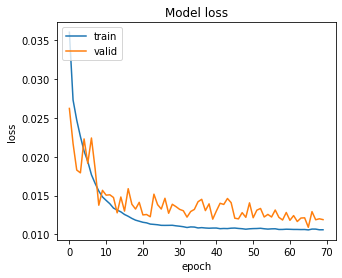

In [ ]:
def display_history(history):
    #Summarize history for accuracy and loss.
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history);

In [ ]:
#model.save('model_CNN.h5')
#Recreate the exact same model, including its weights and the optimizer
model = load_model('model_CNN.h5') 

### <font color='blue'>Performance on Validation Data</font>

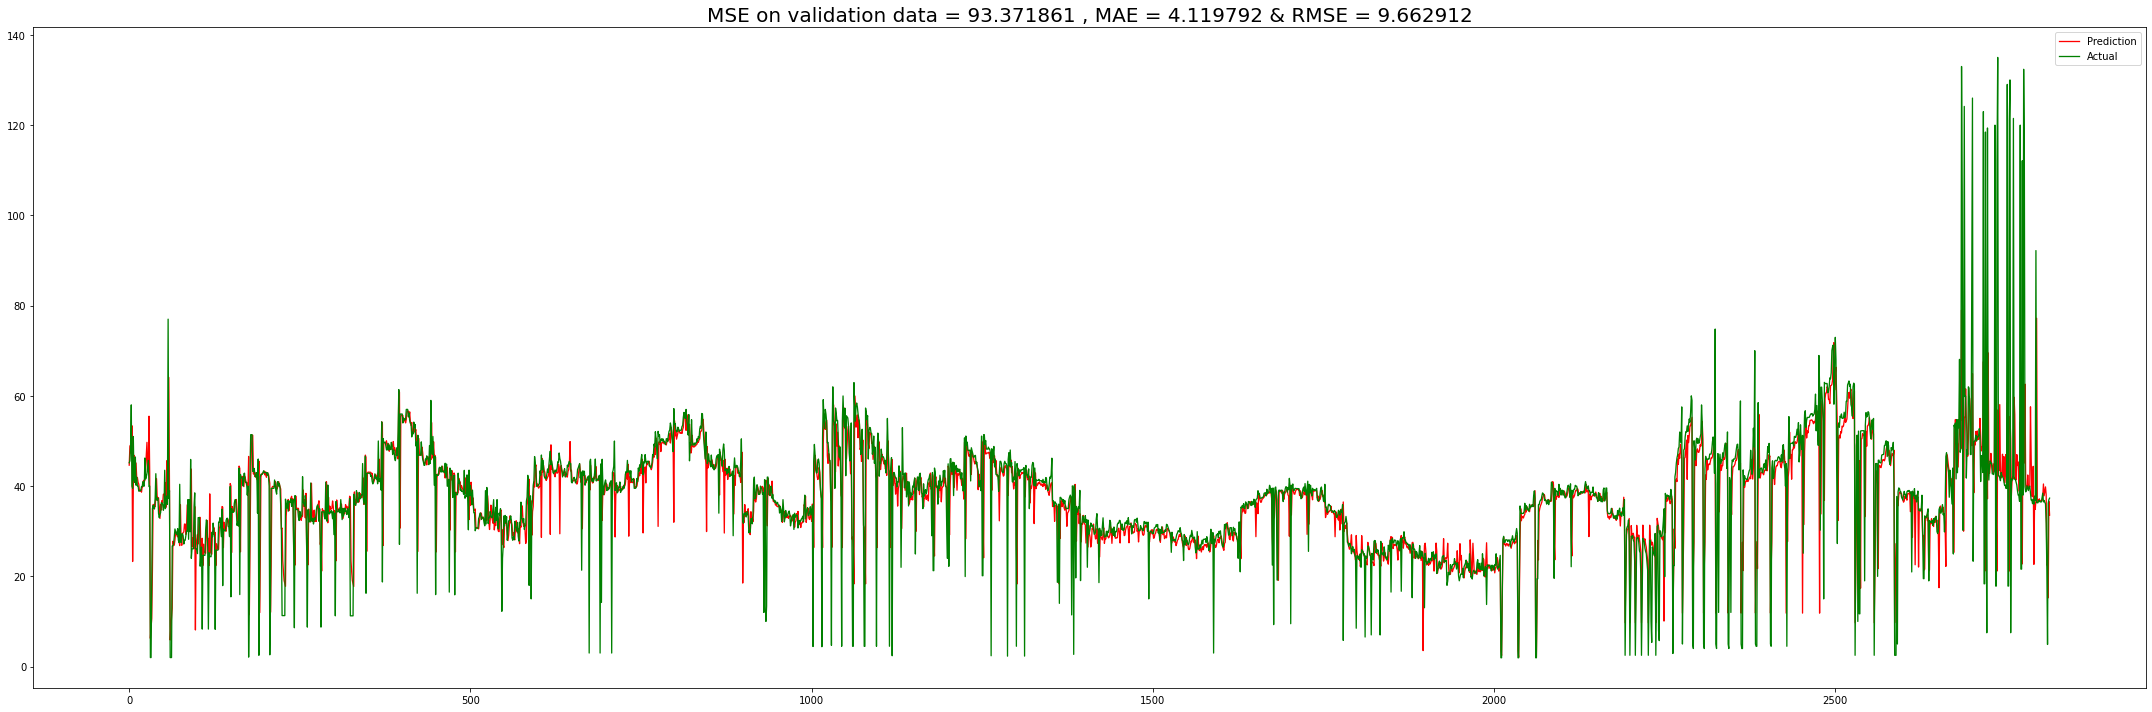

In [ ]:
prediction = plotModelResults(model, X_valid, y_valid, test=False, valid=True, train=False, model_name='CNN')

### <font color='blue'>Performance on Test Data</font>

It is important to check whether or not our model is biased towards the Validation set. We do this by evaluating the model on Test set which the model has never seen. 

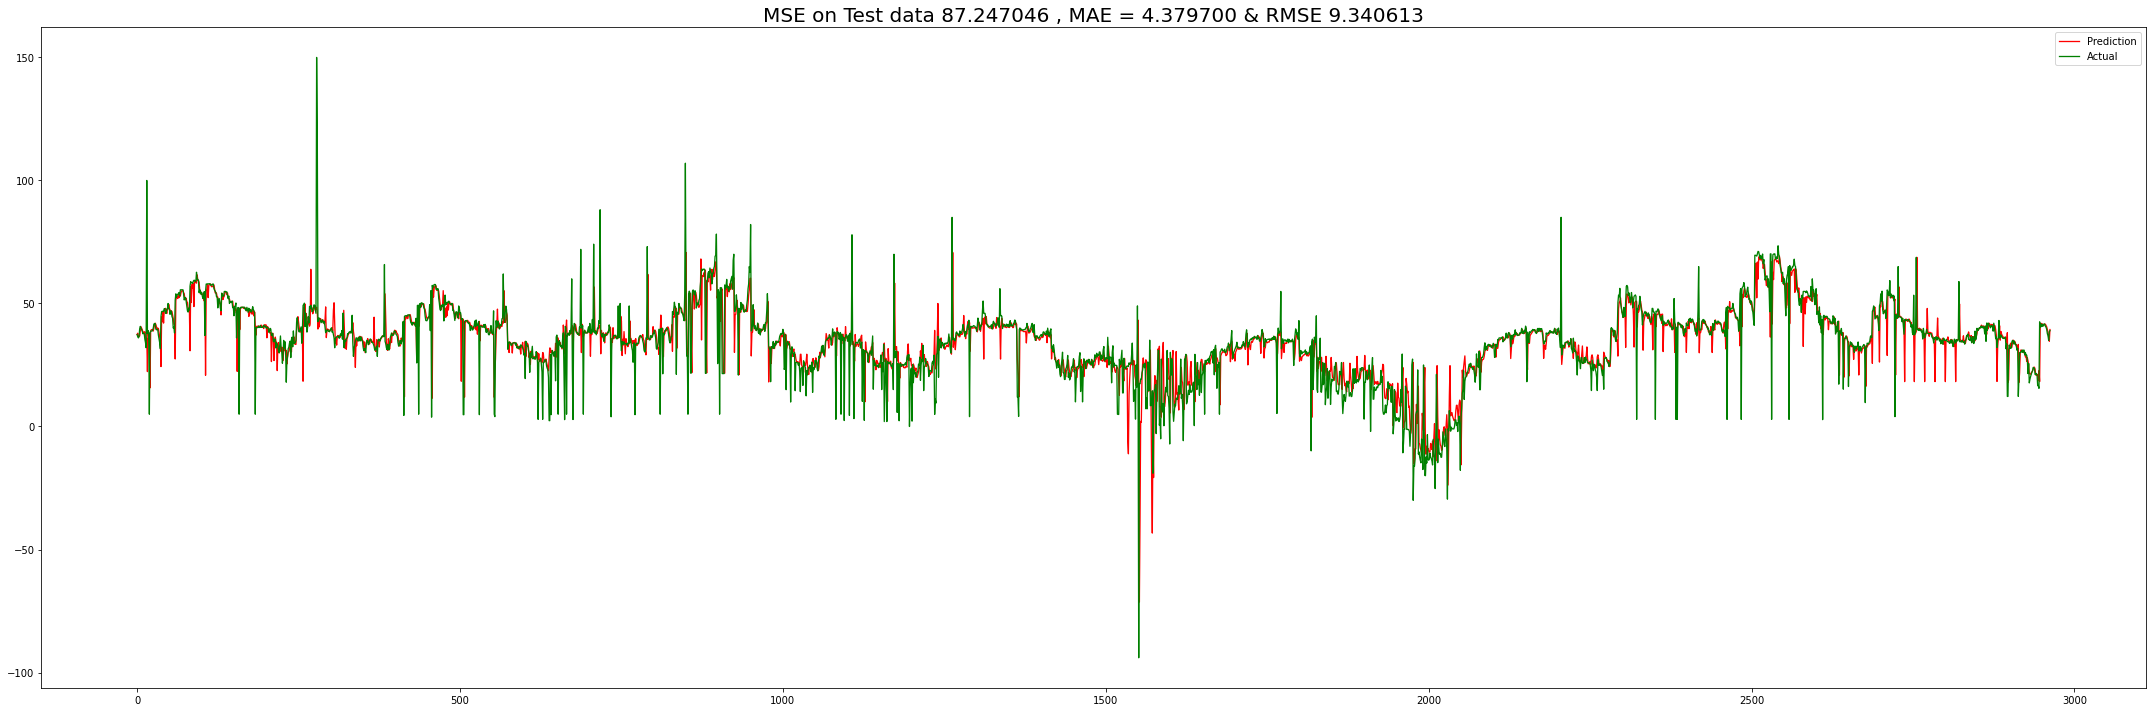

In [ ]:
prediction = plotModelResults(model, X_test, y_test, test=True, valid=False, train=False, model_name='CNN')

## **Long Short Term Memory**

---



In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the Hyperparameters
BATCH_SIZE = 64
EPOCHS = 40
DROPOUT_RATE= 0.2
LEARNING_RATE = 0.001

**Network Archetecture**

In [ ]:
tf.compat.v1.reset_default_graph() 
clear_session()   

# input layer
inputs = Input(shape=(X_train.shape[1],  X_train.shape[2]))

#LSTM layer 1
LSTM_LAYER_1 = LSTM(70, kernel_initializer=glorot_normal(seed=19), return_sequences=True)(inputs)
dropout1 = Dropout(DROPOUT_RATE)(LSTM_LAYER_1)

#LSTM Layer 2
LSTM_LAYER_2 = LSTM(20, kernel_initializer=glorot_normal(seed=19), return_sequences=False, dropout=DROPOUT_RATE)(dropout1)
dropout2 = Dropout(DROPOUT_RATE)(LSTM_LAYER_2)

#Linear Activation Layer output layer
Predictions = Dense(1,  activation='linear', kernel_initializer=glorot_normal(seed=19))(dropout2)

model =  Model(inputs=inputs, outputs=Predictions)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 70)            20160     
_________________________________________________________________
dropout (Dropout)            (None, 21, 70)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                7280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 27,461
Trainable params: 27,461
Non-trainable params: 0
__________________________________________________

Adding more layers were not helping.

**Loss, optimizer, compilation**

In [ ]:
loss = 'mean_absolute_error'
optimizer = Adam(learning_rate=LEARNING_RATE)

# Compilation
model.compile(loss= loss, optimizer= optimizer, metrics='RootMeanSquaredError')

**Training**

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

# Loads the weights if needed
#model.load_weights(checkpoint_filepath)

history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    shuffle=False,
                    callbacks=[model_checkpoint_callback])

Epoch 1/40
836/836 [==============================] - 5s 6ms/step - loss: 0.0519 - root_mean_squared_error: 0.0712 - val_loss: 0.0249 - val_root_mean_squared_error: 0.0357
Epoch 2/40
836/836 [==============================] - 5s 6ms/step - loss: 0.0327 - root_mean_squared_error: 0.0441 - val_loss: 0.0231 - val_root_mean_squared_error: 0.0329
Epoch 3/40
836/836 [==============================] - 5s 6ms/step - loss: 0.0276 - root_mean_squared_error: 0.0390 - val_loss: 0.0220 - val_root_mean_squared_error: 0.0320
Epoch 4/40
836/836 [==============================] - 5s 6ms/step - loss: 0.0251 - root_mean_squared_error: 0.0369 - val_loss: 0.0211 - val_root_mean_squared_error: 0.0313
Epoch 5/40
836/836 [==============================] - 5s 6ms/step - loss: 0.0233 - root_mean_squared_error: 0.0349 - val_loss: 0.0200 - val_root_mean_squared_error: 0.0303
Epoch 6/40
836/836 [==============================] - 5s 6ms/step - loss: 0.0212 - root_mean_squared_error: 0.0321 - val_loss: 0.0186 - val_

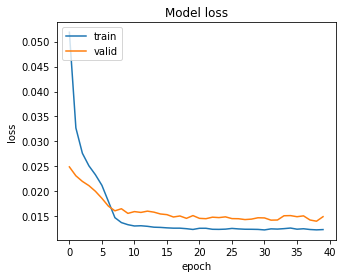

In [ ]:
def display_history(history):
    #Summarize history for loss.
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history)

In [ ]:
# load the weights corresponding to minimum loss
model.load_weights(checkpoint_filepath)

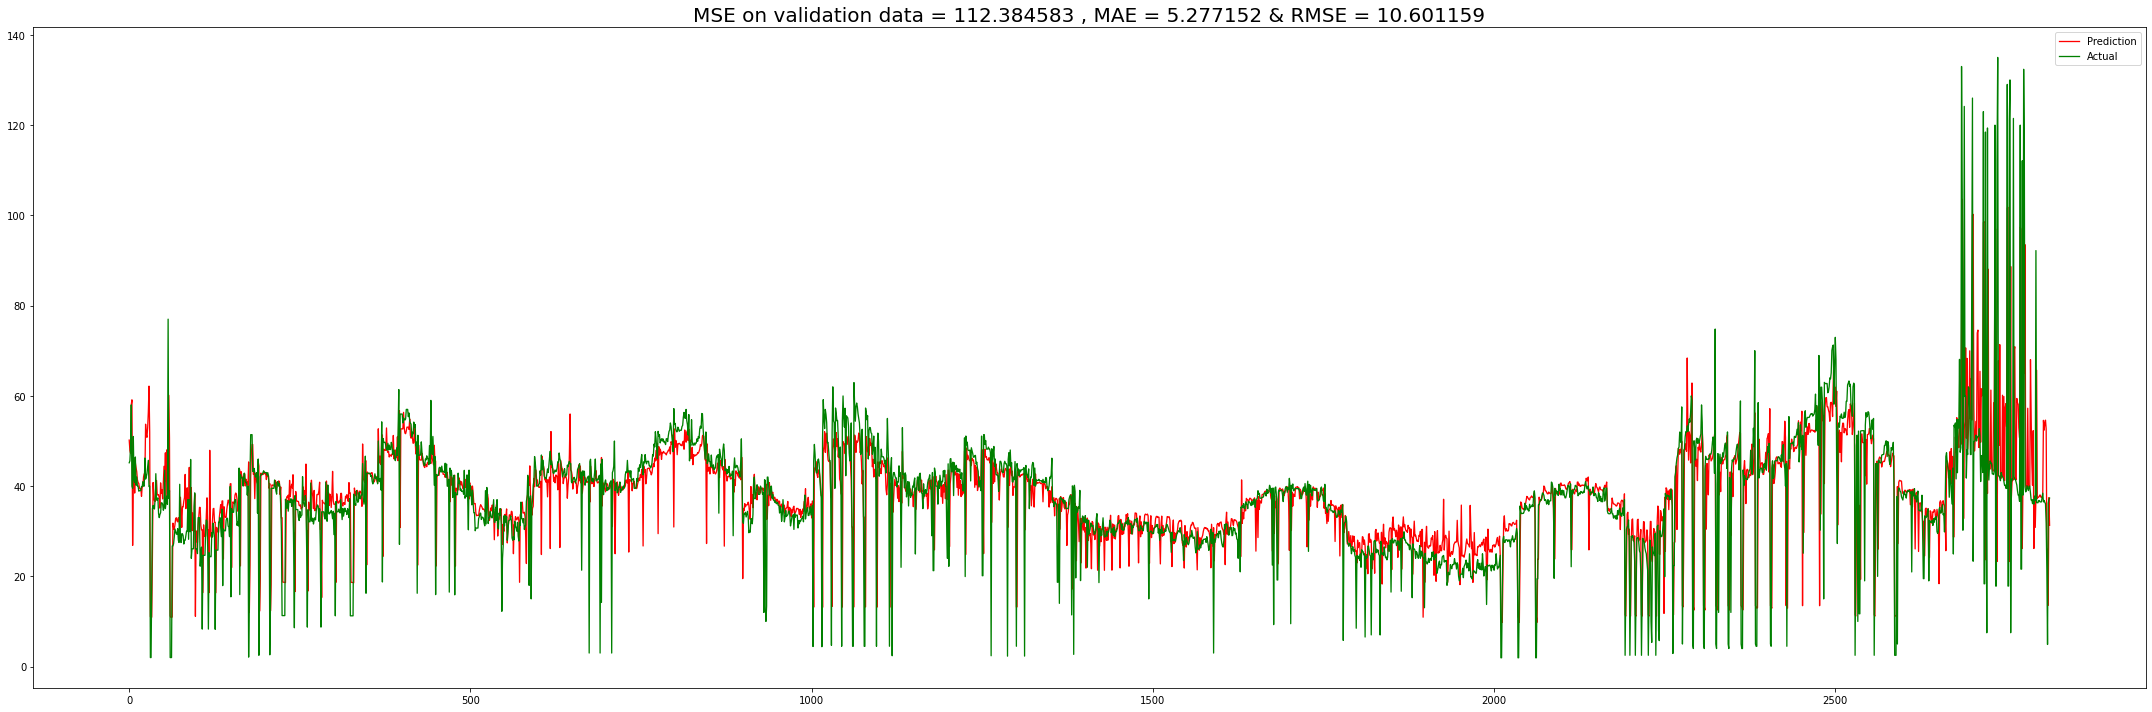

In [ ]:
#prediction on validation data
prediction = plotModelResults(model, X_valid, y_valid, test=False, valid=True, train=False, model_name='LSTM')

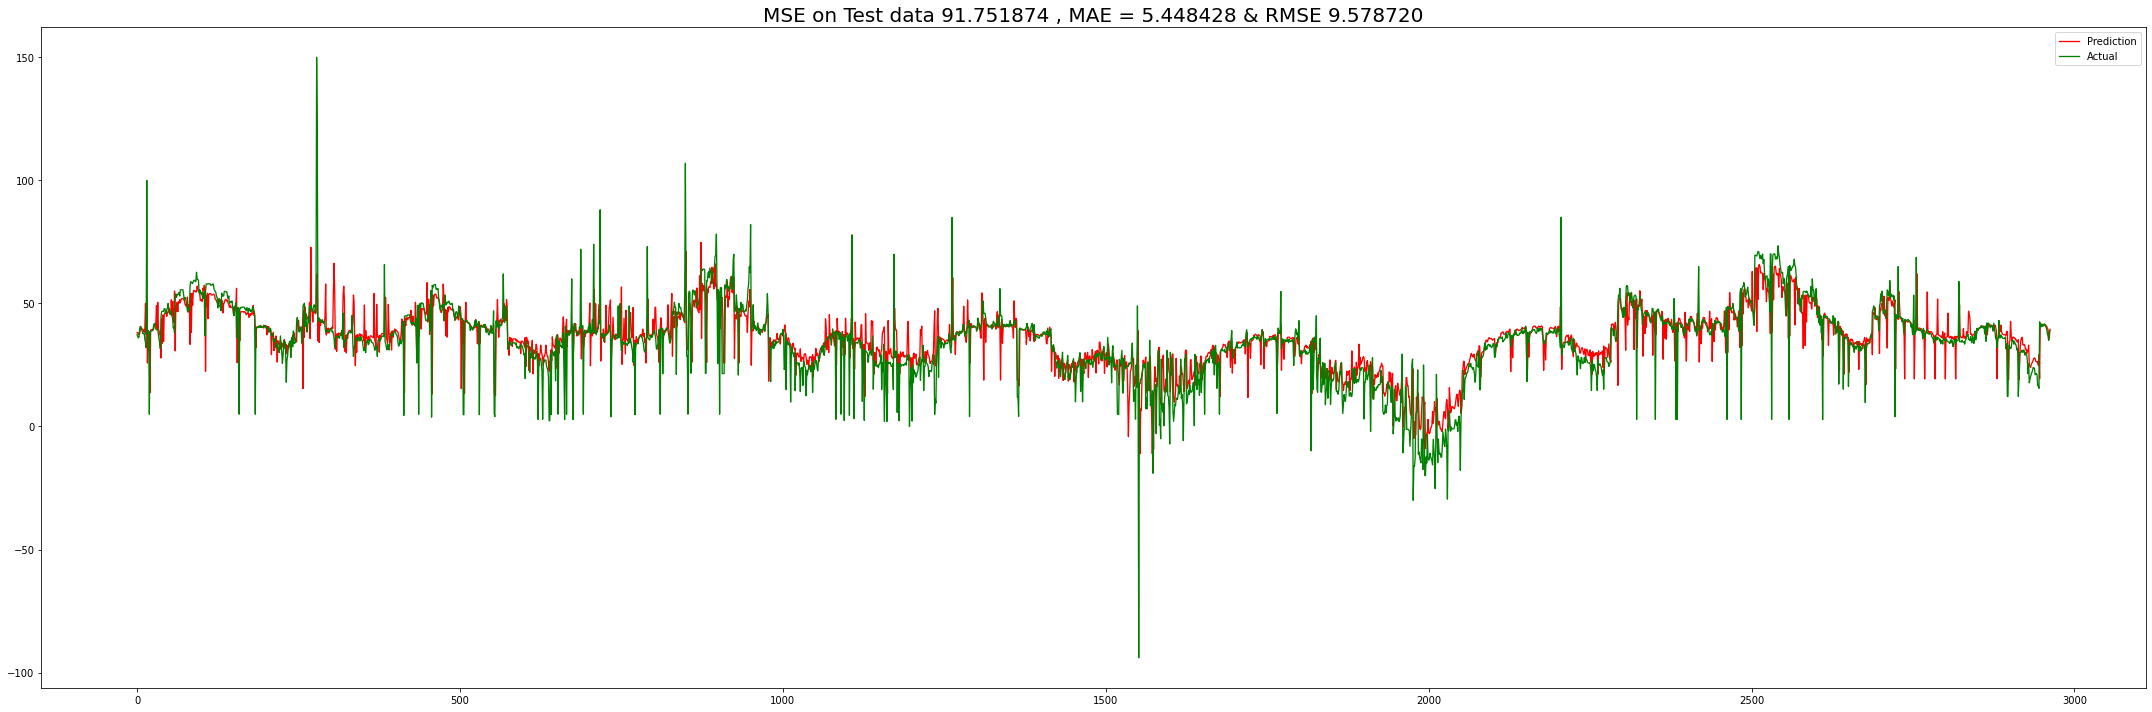

In [ ]:
#prediction on test data
prediction = plotModelResults(model, X_test, y_test, test=True, valid=False, train=False, model_name='LSTM')

In [ ]:
# save the model
model.save('model_LSTM.h5')

## **Hyperparameter Tunning for Random Forest**

---



### For Hyperparameter tuning we will use a vairent of **Sequential Model-Based Global Optimization (SMBO**) which uses the **Tree Parzen Estimator (TPE)** strategy for Expected Improvement as put forward by [Bergstra et al ](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) in the paper **“Algorithms for Hyper-Parameter Optimization”**.

### We will do the search for **Random Forest's Hyperparameters.** 

### <font color='Green'>Idea Behind Bayisan Optimization (Tree Parzen Estimator)</font>

Surrogate Function(TPE):   **P(mse | Hyperparameter)**

Bayes Rule in Action:

**P(mse | Hyperparameter) = (P(Hyperparameter | mse) P(mse)) / P(Hyperparameter)**

According to TPE, **P(Hyperparameter | mse)** is divided into two distributions **l(x)** and **g(x)**. (Unlike Gaussian Process)

Note: TPE takes **mean squared error (mse)** and minimizes it.

**l(x)** = Distribution of Hyperparameters that produces mse below a certain threshold. (Good Hyperparameter values)

**g(x)** = Distribution of Hyperparameters that produces mse greater than or equal to a certain threshold. (Bad Hyperparameter values)

<h3><font color='blue'>Imagine we are dealing with a single Hyperparameter. Points in blue shows the optimal hyperparameter values.</font></h3>

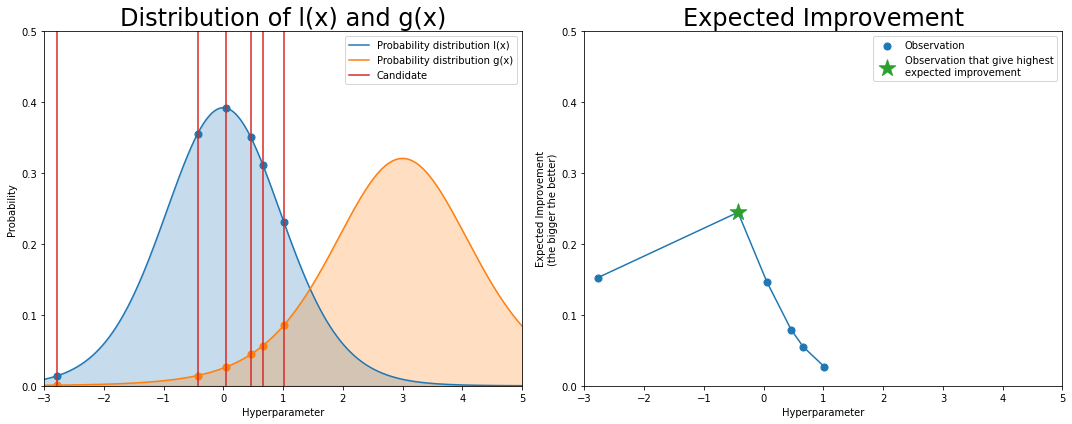

In [ ]:
import random
import time
from scipy import stats
np.random.seed(2)


colors = plt.rcParams['axes.prop_cycle']
colors = [c['color'] for c in colors]

best_proba = stats.t(15, 0, 1)
worst_proba = stats.t(7, 3, 1.2)

x = np.linspace(-3, 5, 1000)
y_best = best_proba.pdf(x)
y_worst = worst_proba.pdf(x)

fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1, 2, 1)

best_proba_line, = ax.plot(x, y_best, color=colors[0])
ax.fill_between(x, 0, y_best, color=colors[0], alpha=0.25)

worst_proba_line, = ax.plot(x, y_worst, color=colors[1], label='g(x)')
ax.fill_between(x, 0, y_worst, color=colors[1], alpha=0.25)

x_candidates = best_proba.rvs(6)
for x_candidate in x_candidates:
    candidate_line = ax.axvline(x_candidate, 0, 1,
                                 color=colors[3])
    ax.scatter(x_candidate, best_proba.pdf(x_candidate),
                s=50, color=colors[0])
    ax.scatter(x_candidate, worst_proba.pdf(x_candidate),
                s=50, color=colors[1])


ax.set_title('Distribution of l(x) and g(x)', size = 24)
plt.ylabel("Probability")
plt.xlabel("Hyperparameter")
plt.xlim(-3, 5)
plt.ylim(0, 0.5)

plt.legend([
        best_proba_line,
        worst_proba_line,
        candidate_line,
    ], [
        'Probability distribution l(x)',
        'Probability distribution g(x)',
        'Candidate',
    ],
    loc='upper right'
)

ax = fig.add_subplot(1, 2, 2)
x_candidates.sort()
expected_improvement = (best_proba.pdf(x_candidates) / worst_proba.pdf(x_candidates))/100
max_index = expected_improvement.argmax()
ax.plot(x_candidates, expected_improvement)
ax.scatter(x_candidates, expected_improvement, color=colors[0], s=50,
            label='Observation')

ax.scatter(x_candidates[max_index], expected_improvement[max_index],
            marker='*', s=300, color=colors[2], zorder=10,
            label='Observation that give highest\nexpected improvement')


ax.set_title('Expected Improvement', size = 24)
plt.ylabel("Expected Improvement\n(the bigger the better)")
plt.xlabel("Hyperparameter")
plt.xlim(-3, 5)
plt.ylim(0, 0.5)
plt.legend(loc='upper right')

fig.tight_layout()
plt.show()

### **l(x) => Good Group**
### **g(x) => Bad Group** 

<h3><font color='blue'>We want to draw samples which are more likely under l(x) rather than g(x). We Maximize the ratio l(x)/g(x). Expected Improvement is directly propotional to l(x)/g(x). The higer this ratio, the greater the Expected improvement will be.</font></h2>


<h3><font color='Green'>l(x) and g(x) makes a mixture of Gaussians. Each mixutre is updated on every iteration after which it is used to sample the next hyperparamter that maximizes the Expected Improvement.</font></h2>



### On each iteration, the algorithm returns the candidate hyperparameter with the **greatest EI**.

### <center><font color='Red'>-------------------------------------Implementation------------------------------------------</font>

In [ ]:
# import necessary libraries

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

"\nimport warnings\nwarnings.filterwarnings('ignore')\nwarnings.filterwarnings(action='ignore',category=DeprecationWarning)\nwarnings.filterwarnings(action='ignore',category=FutureWarning)\n"

**Define search domain**

We applied random forest previously so we have an idea about the hyperparameter combinations of where the Random Forest would perform better. Hence we are not defining the search domain for large hyperparameter ranges.

In [ ]:
param_hyper_opt = {'max_depth': hp.choice('max_depth', range(4, 15)),
                   'max_features': hp.choice('max_features', range(5,21)),
                   'n_estimators': hp.choice('n_estimators', (100, 200, 300, 400, 500))}

#### <font color='blue'>Define Objective Function (The Network) that we want to evaluate and minimize the loss on.</font></h2>

<h4><font color='blue'> The loss on (X_valid, y_valid) is returned to the TPE surrogate function which then makes an informed decision on choosing the next hyperparameters based on this score.</font></h4>

<h4><font color='blue'></font></h4>

In [ ]:
def objective_function(params):
  RF_base_model=RandomForestRegressor(n_estimators=params['n_estimators'], 
                                       max_depth=params['max_depth'], 
                                       random_state=RANDOM_STATE, 
                                       n_jobs=-1)
  
  RF_base_model.fit(X_train, y_train.ravel())
  prediction = RF_base_model.predict(X_valid)
  score = mean_absolute_error(y_valid, prediction)

  print('mae:', score)
  return {'loss': score, 'status': STATUS_OK}

####<font color='blue'>Define the Surrogate Function (Tree Parzen Estimator)</font></h2>
<h4><font color='blue'>We dont want to run the Objective function on every possible combination of hyperparameters unlike Grid Search.</font></h4>
<h4><font color='blue'>We hope to take an informed decison on choosing the next hyperparametrs, no Randomness unlike Random Search.</font></h4>

<h5><font color='blue'>Trial object stores basic training information and the dictionary returned from the objective function (being the scores and their corresponding hyperparameters).</font></h5>

In [ ]:
def hyperopt_function(param_hyper_opt, num_evals):
  trials = Trials()
  best_param = fmin(objective_function,
                    param_hyper_opt, 
                    algo=tpe.suggest, 
                    max_evals=num_evals, 
                    trials=trials,
                    rstate= None)
  return trials, best_param

In [ ]:
# Defining the number of evaluations
num_eval = 50

# calling the TPE(hyperopt) function
results_hyperopt, best = hyperopt_function(param_hyper_opt, num_eval)

mae:
0.011770982111607181
mae:
0.013993733928253314
mae:
0.012319615521272963
mae:
0.012338796457829412
mae:
0.01206853036071824
mae:
0.01201030134351261
mae:
0.012110424105012323
mae:
0.011701071499598887
mae:
0.01286245182556014
mae:
0.012030249074171717
mae:
0.012123652101831679
mae:
0.012819726727449321
mae:
0.012131785438752624
mae:
0.012448737480758254
mae:
0.012588749570378352
mae:
0.011934148486833133
mae:
0.012170111335097137
mae:
0.012454123156996982
mae:
0.011720231056783012
mae:
0.011665790279248947
mae:
0.011684655534150113
mae:
0.011684655534150113
mae:
0.011684655534150113
mae:
0.011783722624890615
mae:
0.011814423816761725
mae:
0.011754520833594231
mae:
0.011741558432379957
mae:
0.011724846803359626
mae:
0.011684655534150113
mae:
0.012333060636520727
mae:
0.011910164527877652
mae:
0.011810278793199456
mae:
0.011845445808934997
mae:
0.012373268383129032
mae:
0.01173768562482101
mae:
0.012256430776119095
mae:
0.01169687910202588
mae:
0.011785019391236483
mae:
0.0120159398

In [ ]:
# Print best parameters
best_params = space_eval(param_hyper_opt, best)
print("BEST PARAMETERS: " + str(best_params))

BEST PARAMETERS: {'max_depth': 13, 'max_features': 6, 'n_estimators': 400}


In [ ]:
# Run the model on best hyperparameters
RF_base_model = RandomForestRegressor(n_estimators=400, 
                                      max_features=6,
                                      max_depth=13, 
                                      random_state=RANDOM_STATE, 
                                      n_jobs=-1)
RF_base_model.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=452543634, verbose=0, warm_start=False)

### <font color='blue'>Performance on Validation Data</font>

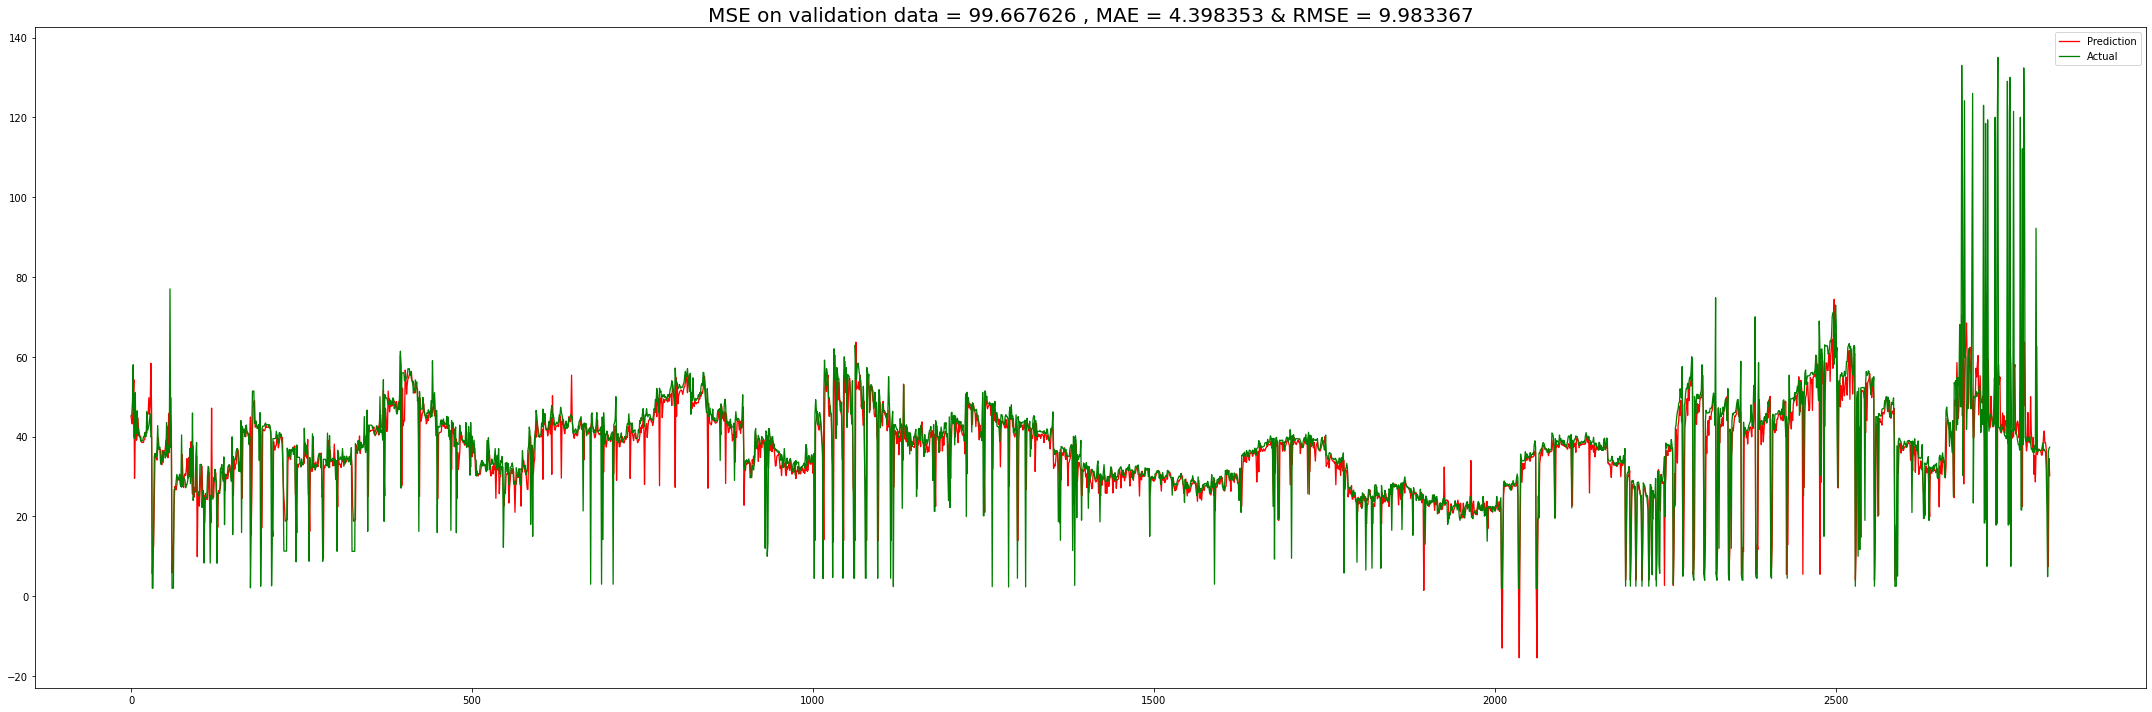

In [ ]:
prediction = plotModelResults(RF_base_model, X_valid, y_valid, test=False, valid=True, train=False, model_name = 'RF_base_model')

### <font color='blue'>Performance on Test Data</font>

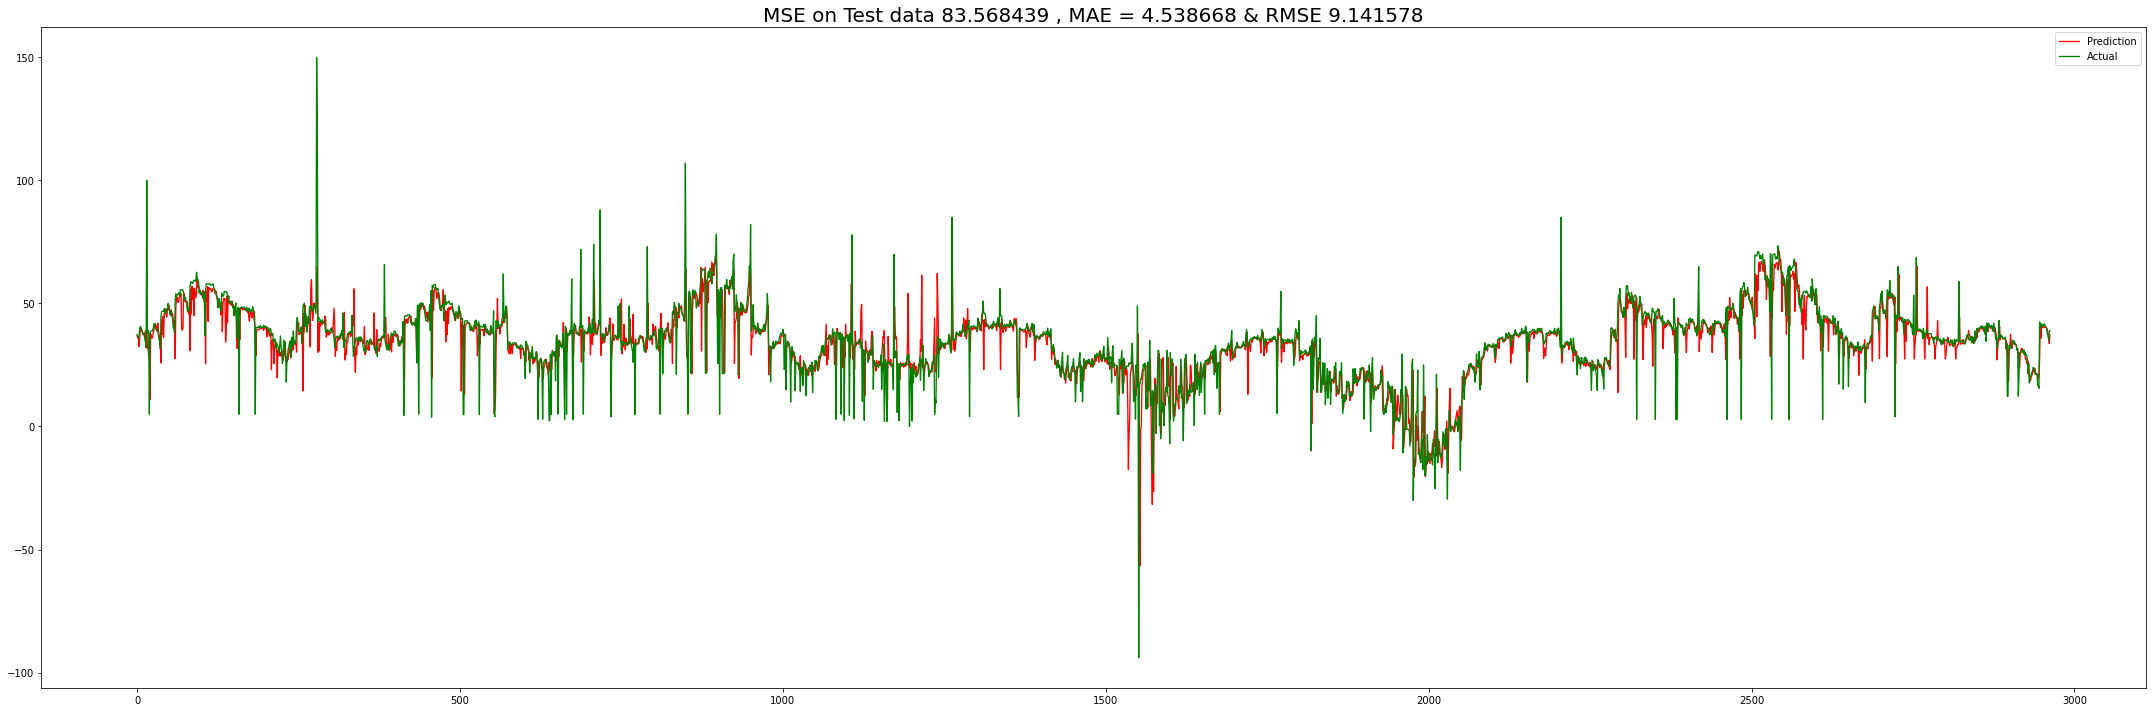

In [ ]:
prediction = plotModelResults(RF_base_model, X_test, y_test, test=True, valid=False, train=False, model_name = 'RF_base_model')

# **Conclusion and Next steps**

---



### **Results:**

![](https://drive.google.com/uc?export=view&id=1ZW6GZyixMtckopriqvlX15BbxOSy900K)




Based on the results, we conclude that CNN has performed better than other algorithms based on Mean Absolute Error. 

### **Next Steps**

For models to perform even better next step should be to further improve feature engineering. Since one of the bigger part of electricity production is also renewable energy that is wind, sun etc, hence it would make sense to further evaluate the models by having hourly weather information in our dataset i.e wind speed, sun shine, cloudy etc. 

We also noticed that our models were not able to predict big spikes in the closing price in validation and test data. Again better feature engineering could have helped to cater that problem.